In [5]:
import networkx as nx
import datetime
import secrets

# exact solver
import dwave_networkx as dnx
from dimod.reference.samplers import ExactSolver

#quantum solver
from dwave.system import DWaveSampler, EmbeddingComposite
import dwave

import statistics
import matplotlib.pyplot as plt
import matplotlib as mpl

# Setup

First we need to define the example edge dictionary from the paper to test our hypothesis in situ. This is what it looks like in code:

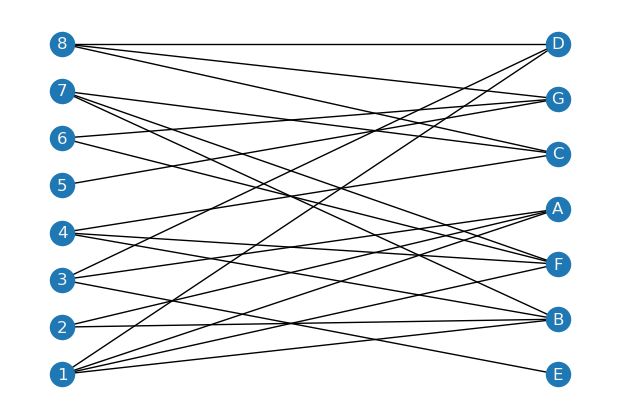

In [39]:
edge_dict = {
    1:['A','B','D','F'],
    2:['A','B'],
    3:['A','D','E'],
    4:['B','C','F'],
    5:['G'],
    6:['F','G'],
    7:['B','C','F'],
    8:['C','D','G']
}

B = nx.Graph()
B.add_nodes_from([1,2,3,4,5,6,7,8], bipartite=0)
B.add_nodes_from(['A','B','C','D','E','F','G'], bipartite=1)
for u in range(1,9):
    for v in edge_dict[u]:
        B.add_edge(u,v)
X,Y=nx.bipartite.sets(B)
nx.draw(B, pos=nx.bipartite_layout(B,X), with_labels=True, font_color="whitesmoke")

We now parse the bipatite graph and produce the dual defined in the paper. 

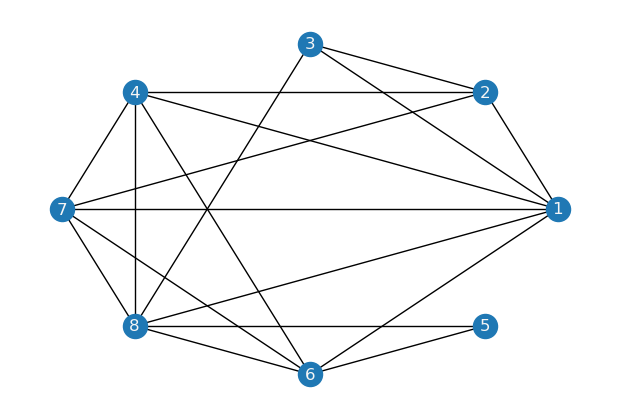

In [40]:
B_dual = nx.Graph()

B_2 = B.copy()

S,T = nx.bipartite.sets(B_2)
#nx.draw(B_2, pos=nx.bipartite_layout(B_2,S), with_labels=True)

# iterate over one side of the bipartite graph
# and construct the dual from the paper.
def gen_dual(B_2, S=None):
    B_2c = B_2.copy()
    DualG = nx.Graph()
    if not S:
        S,_ = nx.bipartite.sets(B_2c)
    for s in S:
        DualG.add_node(s)
        # iter over all nodes s talks to
        for t1 in B_2c.neighbors(s):
            for t2 in B_2c.neighbors(t1):
                if t2 != s:
                    DualG.add_edge(s, t2)
        B_2c.remove_node(s)
    return DualG
DG = gen_dual(B_2, S)
nx.draw(DG,pos=nx.circular_layout(DG), with_labels=True, font_color="whitesmoke")

## Solving with a Vertex Cover

To work out the MVC for this dual, we use first the classical exact solver, and we can see that the desired effect - the graph being disconnected from the vulnerability side of the original bipartite graph - is achieved.

In [41]:
import dwave_networkx as dnx
from dimod.reference.samplers import ExactSolver
sampler = ExactSolver()
vc = dnx.min_vertex_cover(DG, sampler)
print(vc)

[1, 2, 4, 8, 6]


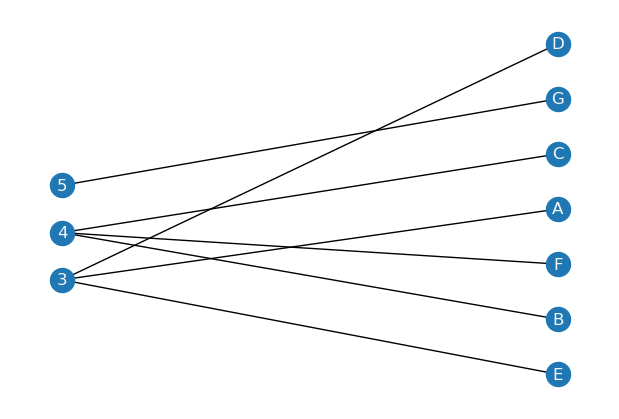

In [42]:
check_B = B.copy()
vc2 = [1,2,6,7,8]
for v in vc2:
    check_B.remove_node(v)

nx.draw(check_B, pos=nx.bipartite_layout(check_B,S), with_labels=True, font_color="whitesmoke")

In [45]:
# timed classical solver
def timed_classical_solve(G):
    sampler = ExactSolver()
    start_time = datetime.datetime.now()
    test = dnx.min_vertex_cover(G, sampler)
    end_time = datetime.datetime.now()
    c = end_time - start_time
    print("{} seconds, {} microseconds".format(c.seconds, c.microseconds))
    # this will give [1, 2, 4, 6, 8] - the exact solution
    print("Results: {}".format(test))
    return test, c

timed_classical_solve(G)

0 seconds, 3174 microseconds
Results: [1, 2, 4, 6, 8]


([1, 2, 4, 6, 8], datetime.timedelta(microseconds=3174))

In [14]:
# Quantum solver time! 

sampler = EmbeddingComposite(DWaveSampler())
print(dnx.min_vertex_cover(G, sampler))

[1, 2, 6, 7, 8]


# Random Bipartite Graphs

To see how effective our methods are, we generate random bipartite vulnerability graphs with varying edge probabilities. We can then compare these - as shown in the original paper.

In [46]:
# timed quantum solver

# We first build a manual MVC solver, based on code from DWave. 
# This allows us more granular control over the outputs, and for us 
# to control and view the raw data from the DWave annealer.

def mvc_manual(G, sampler, **sampler_args):
    if not G:
        return {}
    weight='weight'
    lagrange = 2.0
    # a manual version so we can get more detail out
    cost = dict(G.nodes(data=weight, default=1))
    scale = max(cost.values())
    Q = {(node, node): min(-cost[node] / scale, 0.0) for node in G}
    Q.update({edge: lagrange for edge in G.edges})
    # now pass to the sampler
    response = sampler.sample_qubo(Q, **sampler_args)
    sample = next(iter(response)) # get lowest value
    # independent set S
    S = [node for node in sample if sample[node] > 0]
    independent_nodes = set(S)
    MVC = [v for v in G if v not in independent_nodes]
    return response, S, MVC


def timed_quantum_solver(G):
    sampler = EmbeddingComposite(DWaveSampler())
    start_time = datetime.datetime.now()
    test = dnx.min_vertex_cover(G, sampler)
    end_time = datetime.datetime.now()
    c = end_time - start_time
    print("{} seconds, {} microseconds".format(c.seconds, c.microseconds))
    print("Results: {}".format(test))
    return test

#sampler = EmbeddingComposite(DWaveSampler())
#r,s,m = mvc_manual(G, sampler)
#print(r)
#print(s)
#print(m)

#timed_quantum_solver(G)

In [47]:
# validator for results! These use the original example from the paper/above.
test_res_good1 = [1,2,4,6,8]
test_res_good2 = [1,2,6,7,8]
test_res_bad1 = [1,2,3,4,5,6]
test_res_bad2 = [1,2,5,6,8]

def validate_solution(mvc_candidate, B, T=None):
    cB = B.copy()
    if not T:
        _,T = nx.bipartite.sets(cB)
    # remove the nodes in the candidate MVC for the dual from the copy of the Bipartite graph
    for v in mvc_candidate:
        cB.remove_node(v)
    # iterate over the set of host nodes, T, and check
    # their degree is never greater than 1
    for h in T:
        if cB.degree(h) > 1:
            return False
    return True

test_res_lst = [test_res_good1, test_res_good2, test_res_bad1, test_res_bad2]
for t in test_res_lst:
    print(validate_solution(t, B))

True
True
False
False


## Graph Generator

This is our random graph generator. There are several commented-out variations for graph edge probabilities between the two sides of our bipartite graphs. These are preserved as they were used to generate the data in the paper, but can easily be replaced with parameters.

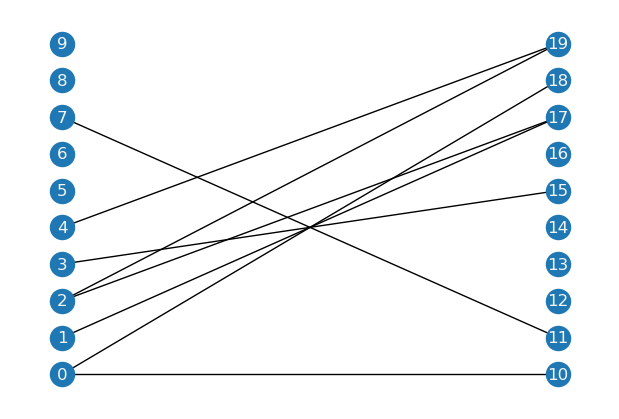

In [48]:
def gen_bit():
    a = secrets.randbits(1)
    b = secrets.randbits(1)
    if a != b:
        return a
    return gen_bits()

def gen_graph(n1=3, n2=3):
    B = nx.Graph()
    vulns = list(range(0 ,n1))
    hosts = list(range(n1,n1+n2))
    B.add_nodes_from(vulns, bipartite=0)
    B.add_nodes_from(hosts, bipartite=1)
    for v in vulns:
        for h in hosts:
            # set probability of edge here
            # randbits(1) == 1 -- 50%
            # randbits(2) == 2 -- 25%
            # randbelow(3) == 0 -- 33%
            # randbelow(3) != 0 -- 66%
            if secrets.randbelow(10) == 1:
                B.add_edge(v,h)
    return B


n1 = 10
n2 = 10
vulns = list(range(0,n1))
hosts = list(range(n1,n1+n2))
testB = gen_graph(n1,n2)
#print(testB.edges)
nx.draw(testB, pos=nx.bipartite_layout(testB,vulns), with_labels=True, font_color="whitesmoke")



A quick test of the generator and validator code:

In [14]:
D_B = gen_dual(testB,S=vulns)
print(D_B.edges)
test_result,_ = timed_classical_solve(D_B)
print(test_result)
print(validate_solution(test_result, testB,T=hosts))

[(1, 2), (1, 9), (1, 3), (1, 6), (1, 5), (1, 8), (1, 4), (2, 9), (2, 3), (2, 5), (2, 8), (2, 6), (2, 4), (9, 4), (9, 5), (3, 6), (3, 5), (3, 8), (3, 4), (6, 4), (6, 5), (6, 7), (6, 8), (5, 4), (5, 8), (5, 7), (8, 4), (8, 7)]
0 seconds, 9884 microseconds
Results: [1, 2, 6, 5, 8, 4]
[1, 2, 6, 5, 8, 4]
True


In [160]:
qtest_result = timed_quantum_solver(D_B)
print(qtest_result)
print(validate_solution(qtest_result, testB,T=hosts))

6 seconds, 68534 microseconds
Results: [0, 5, 8, 9, 3, 7, 2, 4]
[0, 5, 8, 9, 3, 7, 2, 4]
False


# Test Runs

We now run various tests over large numbers of graphs:
* We generate graphs with 8 to 24 vulnerabilities
* This gives us graphs with 16 to 48 nodes on the bipartite graphs, and then 8 to 24 nodes in their duals.
* We calculate the MVCs for all of these duals, and time them classicaly and quantumly. 

The first few cells are tests, then the main runs are below.

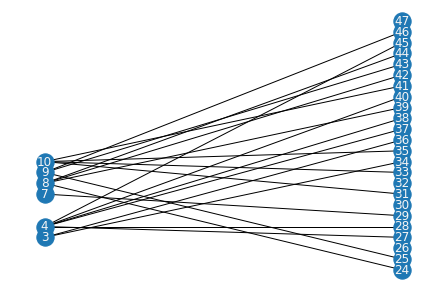

In [142]:
testB2 = testB.copy()
for v in test_result:
    testB2.remove_node(v)
nx.draw(testB2, pos=nx.bipartite_layout(testB2,vulns), with_labels=True, font_color="whitesmoke")

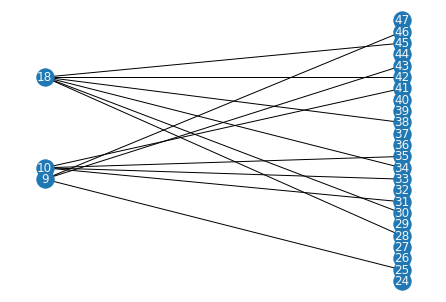

In [143]:
testB2 = testB.copy()
for v in qtest_result:
    testB2.remove_node(v)
nx.draw(testB2, pos=nx.bipartite_layout(testB2,vulns), with_labels=True, font_color="whitesmoke")

In [12]:
def run_exp(strt,nd,reps):
    for i in range(strt,nd):
        print("===== NEW NODE COUNT: {} =====".format(i))
        res_summary = []
        for j in range(reps):
            print("=== NEW GRAPH (number {}) ===".format(j))
            vulns = list(range(0,i))
            hosts = list(range(i,i+i))
            Bg = gen_graph(i,i)
            D_Bg = gen_dual(Bg,S=vulns)
            #ctest_result, time_taken = timed_classical_solve(D_Bg)
            #print("MVC: {}".format(ctest_result))
            #print("Length of MVC: {}".format(len(ctest_result)))
            #print("Time taken: {}".format(time_taken))
            #print("Valid? {}".format(validate_solution(ctest_result, Bg,T=hosts)))
            # now run it on quantum
            sampler = EmbeddingComposite(DWaveSampler())
            r,s,mvc = mvc_manual(D_Bg, sampler)
            r_vals = list(r.info.values())
            time_taken_q = r_vals[0]['qpu_programming_time']+r_vals[0]['qpu_sampling_time']+r_vals[0]['qpu_access_overhead_time']
            print("MVC: {}".format(mvc))
            print("independent set: {}".format(s))
            print("Length of MVC: {}".format(len(mvc)))
            print("Time taken: {}".format(time_taken_q))
            print("Valid? {}".format(validate_solution(mvc, Bg,T=hosts)))
            print("Problem ID: {}".format(r_vals[1]))
        

In [194]:
run_exp(8,25,3)

===== NEW NODE COUNT: 8 =====
=== NEW GRAPH (number 0) ===
0 seconds, 22856 microseconds
Results: [0, 2, 7, 1, 3]
MVC: [0, 2, 7, 1, 3]
Length of MVC: 5
Time taken: 0:00:00.022856
Valid? True
MVC: [0, 2, 7, 1, 3]
independent set: [4, 5, 6]
Length of MVC: 5
Time taken: 17197.0
Valid? True
Problem ID: 5667a4ee-f369-442c-8fc9-a1964cecefb8
=== NEW GRAPH (number 1) ===
0 seconds, 3575 microseconds
Results: [0, 2, 6, 7, 1, 3, 5]
MVC: [0, 2, 6, 7, 1, 3, 5]
Length of MVC: 7
Time taken: 0:00:00.003575
Valid? True
MVC: [0, 2, 6, 7, 1, 4, 5]
independent set: [3]
Length of MVC: 7
Time taken: 16814.0
Valid? True
Problem ID: 1d6099ca-b20f-4e8e-bac8-dc21d8ab185c
=== NEW GRAPH (number 2) ===
0 seconds, 2163 microseconds
Results: [1, 5, 7, 2, 4, 3]
MVC: [1, 5, 7, 2, 4, 3]
Length of MVC: 6
Time taken: 0:00:00.002163
Valid? True
MVC: [1, 5, 7, 2, 4, 3]
independent set: [0, 6]
Length of MVC: 6
Time taken: 17721.0
Valid? True
Problem ID: 77015ac1-3cda-4ec1-9fce-4b85fff0dd6a
===== NEW NODE COUNT: 9 =====
===

MVC: [0, 1, 2, 5, 10, 11, 14, 6, 7, 8, 12, 4, 13]
independent set: [3, 9]
Length of MVC: 13
Time taken: 15474.0
Valid? False
Problem ID: c23cfa5b-b66e-4c3b-a693-51c8cadfbe4c
===== NEW NODE COUNT: 16 =====
=== NEW GRAPH (number 0) ===
0 seconds, 85154 microseconds
Results: [0, 1, 3, 4, 6, 7, 8, 11, 12, 13, 14, 15, 5, 2, 10]
MVC: [0, 1, 3, 4, 6, 7, 8, 11, 12, 13, 14, 15, 5, 2, 10]
Length of MVC: 15
Time taken: 0:00:00.085154
Valid? True
MVC: [0, 1, 4, 6, 7, 8, 12, 13, 14, 15, 5, 2, 9, 10]
independent set: [3, 11]
Length of MVC: 14
Time taken: 16244.0
Valid? False
Problem ID: 753fe23f-4499-4adb-8eb1-77d43e2dfaa3
=== NEW GRAPH (number 1) ===
0 seconds, 84309 microseconds
Results: [0, 1, 2, 3, 4, 5, 6, 9, 12, 13, 14, 8, 7, 10, 11]
MVC: [0, 1, 2, 3, 4, 5, 6, 9, 12, 13, 14, 8, 7, 10, 11]
Length of MVC: 15
Time taken: 0:00:00.084309
Valid? True
MVC: [0, 1, 2, 3, 5, 6, 9, 13, 14, 8, 7, 10, 15, 11]
independent set: [4, 12]
Length of MVC: 14
Time taken: 16447.0
Valid? False
Problem ID: face041c-6

3 seconds, 792813 microseconds
Results: [0, 1, 3, 4, 5, 9, 10, 11, 12, 14, 15, 19, 20, 21, 13, 17, 18, 7, 8, 6]
MVC: [0, 1, 3, 4, 5, 9, 10, 11, 12, 14, 15, 19, 20, 21, 13, 17, 18, 7, 8, 6]
Length of MVC: 20
Time taken: 0:00:03.792813
Valid? True
MVC: [0, 1, 4, 5, 9, 10, 12, 14, 15, 16, 19, 20, 21, 13, 17, 7, 8, 6, 2]
independent set: [3, 11, 18]
Length of MVC: 19
Time taken: 16810.0
Valid? False
Problem ID: a00894e1-d2dc-47b3-8ec2-d805253aae1d
=== NEW GRAPH (number 1) ===
3 seconds, 830991 microseconds
Results: [0, 4, 15, 18, 19, 20, 2, 3, 8, 10, 12, 16, 21, 1, 7, 17, 5, 6, 9, 13]
MVC: [0, 4, 15, 18, 19, 20, 2, 3, 8, 10, 12, 16, 21, 1, 7, 17, 5, 6, 9, 13]
Length of MVC: 20
Time taken: 0:00:03.830991
Valid? True
MVC: [0, 4, 14, 15, 18, 19, 20, 2, 8, 10, 12, 16, 21, 1, 7, 11, 17, 5, 6, 13]
independent set: [3, 9]
Length of MVC: 20
Time taken: 17407.0
Valid? False
Problem ID: 6dab2e63-f055-4869-bab2-8421fdc17a88
=== NEW GRAPH (number 2) ===
3 seconds, 804061 microseconds
Results: [0, 3, 6

In [210]:
run_exp(8,25,3) # re-run for 1/3% chance of edge

===== NEW NODE COUNT: 8 =====
=== NEW GRAPH (number 0) ===
0 seconds, 6385 microseconds
Results: [0, 2, 4, 5]
MVC: [0, 2, 4, 5]
Length of MVC: 4
Time taken: 0:00:00.006385
Valid? True
MVC: [0, 2, 1, 5]
independent set: [3, 4, 6, 7]
Length of MVC: 4
Time taken: 15184.44
Valid? True
Problem ID: 076eacf2-ce65-4a6b-a4b6-7e59d25728ef
=== NEW GRAPH (number 1) ===
0 seconds, 2466 microseconds
Results: [1, 2, 3, 5, 6]
MVC: [1, 2, 3, 5, 6]
Length of MVC: 5
Time taken: 0:00:00.002466
Valid? True
MVC: [1, 2, 3, 5, 6, 4]
independent set: [0, 7]
Length of MVC: 6
Time taken: 16550.0
Valid? True
Problem ID: 15481e0c-d6ba-4d78-ba5c-598ae25913b9
=== NEW GRAPH (number 2) ===
0 seconds, 4429 microseconds
Results: [4, 7, 1, 2, 3]
MVC: [4, 7, 1, 2, 3]
Length of MVC: 5
Time taken: 0:00:00.004429
Valid? True
MVC: [0, 4, 7, 2, 3, 5]
independent set: [1, 6]
Length of MVC: 6
Time taken: 15632.0
Valid? True
Problem ID: a74addb3-6a7d-457b-a39c-ebd3cb399fc9
===== NEW NODE COUNT: 9 =====
=== NEW GRAPH (number 0) ==

MVC: [0, 7, 13, 4, 5, 12, 14, 1, 6, 10, 3, 9, 8]
independent set: [2, 11]
Length of MVC: 13
Time taken: 16011.0
Valid? True
Problem ID: 69e99ffa-2968-463f-bcb0-955fe87609f9
===== NEW NODE COUNT: 16 =====
=== NEW GRAPH (number 0) ===
0 seconds, 68577 microseconds
Results: [0, 1, 2, 5, 8, 9, 13, 10, 15, 3, 7, 11]
MVC: [0, 1, 2, 5, 8, 9, 13, 10, 15, 3, 7, 11]
Length of MVC: 12
Time taken: 0:00:00.068577
Valid? True
MVC: [0, 5, 8, 9, 12, 13, 10, 14, 15, 3, 7, 11, 4, 6]
independent set: [1, 2]
Length of MVC: 14
Time taken: 16890.0
Valid? False
Problem ID: 4e511ca7-d964-40d4-8639-c90040913d26
=== NEW GRAPH (number 1) ===
0 seconds, 87134 microseconds
Results: [0, 2, 11, 12, 1, 7, 13, 14, 9, 3, 5, 6, 10]
MVC: [0, 2, 11, 12, 1, 7, 13, 14, 9, 3, 5, 6, 10]
Length of MVC: 13
Time taken: 0:00:00.087134
Valid? True
MVC: [0, 2, 11, 12, 1, 7, 13, 14, 3, 5, 6, 10, 4, 8]
independent set: [9, 15]
Length of MVC: 14
Time taken: 15657.0
Valid? True
Problem ID: 74ca7166-1dc5-4036-92b7-db7fb6f72794
=== NEW G

RuntimeError: can't start new thread

In [16]:
run_exp(18,25,3) # re-run for 1/3% chance of edge from 18

===== NEW NODE COUNT: 18 =====
=== NEW GRAPH (number 0) ===
0 seconds, 250605 microseconds
Results: [0, 2, 5, 8, 10, 16, 1, 17, 3, 7, 9, 11, 13, 14, 4, 12]
MVC: [0, 2, 5, 8, 10, 16, 1, 17, 3, 7, 9, 11, 13, 14, 4, 12]
Length of MVC: 16
Time taken: 0:00:00.250605
Valid? True
MVC: [0, 2, 8, 10, 16, 1, 6, 17, 3, 11, 13, 14, 4, 15, 12]
independent set: [5, 7, 9]
Length of MVC: 15
Time taken: 19124.0
Valid? False
Problem ID: b8bbfbe2-78db-4a6d-b892-4ed1516a7316
=== NEW GRAPH (number 1) ===
0 seconds, 247067 microseconds
Results: [0, 6, 7, 11, 16, 17, 5, 8, 10, 15, 2, 4, 12, 1, 3, 14]
MVC: [0, 6, 7, 11, 16, 17, 5, 8, 10, 15, 2, 4, 12, 1, 3, 14]
Length of MVC: 16
Time taken: 0:00:00.247067
Valid? True
MVC: [0, 6, 7, 11, 16, 17, 5, 8, 10, 13, 15, 2, 4, 1, 3, 14]
independent set: [9, 12]
Length of MVC: 16
Time taken: 15380.0
Valid? False
Problem ID: da48b510-bf6d-45e0-b125-3cd4493ccf93
=== NEW GRAPH (number 2) ===
0 seconds, 251095 microseconds
Results: [0, 3, 6, 9, 12, 13, 1, 7, 10, 14, 15, 16,

17 seconds, 273285 microseconds
Results: [0, 1, 2, 3, 9, 10, 11, 12, 14, 21, 5, 8, 15, 16, 23, 13, 19, 20, 22, 6, 4]
MVC: [0, 1, 2, 3, 9, 10, 11, 12, 14, 21, 5, 8, 15, 16, 23, 13, 19, 20, 22, 6, 4]
Length of MVC: 21
Time taken: 0:00:17.273285
Valid? True
MVC: [0, 1, 2, 3, 9, 10, 11, 12, 14, 17, 21, 5, 8, 15, 16, 23, 7, 19, 20, 22, 6, 4]
independent set: [13, 18]
Length of MVC: 22
Time taken: 19251.0
Valid? True
Problem ID: 2d6c80f2-85df-4b60-9baa-71fcedbdc928
=== NEW GRAPH (number 1) ===
16 seconds, 986739 microseconds
Results: [0, 4, 18, 19, 22, 9, 12, 20, 21, 1, 2, 7, 15, 16, 17, 3, 11, 13, 5, 8, 23]
MVC: [0, 4, 18, 19, 22, 9, 12, 20, 21, 1, 2, 7, 15, 16, 17, 3, 11, 13, 5, 8, 23]
Length of MVC: 21
Time taken: 0:00:16.986739
Valid? True
MVC: [0, 4, 18, 19, 22, 9, 12, 20, 21, 1, 2, 7, 15, 17, 3, 10, 11, 13, 5, 8, 23]
independent set: [6, 14, 16]
Length of MVC: 21
Time taken: 15460.0
Valid? False
Problem ID: d5d1e16d-74e1-4a54-a510-5d2034d6600c
=== NEW GRAPH (number 2) ===
16 seconds, 8

In [14]:
run_exp(8,25,3) # re-run for 2/3% chance of edge

===== NEW NODE COUNT: 8 =====
=== NEW GRAPH (number 0) ===
0 seconds, 7528 microseconds
Results: [0, 1, 3, 4, 6, 2, 7]
MVC: [0, 1, 3, 4, 6, 2, 7]
Length of MVC: 7
Time taken: 0:00:00.007528
Valid? True
MVC: [0, 1, 6, 2, 5, 7]
independent set: [3, 4]
Length of MVC: 6
Time taken: 16322.0
Valid? False
Problem ID: e4a6416e-1cfb-4f18-8020-bcd84dea3d10
=== NEW GRAPH (number 1) ===
0 seconds, 2203 microseconds
Results: [0, 1, 2, 5, 6, 7, 4]
MVC: [0, 1, 2, 5, 6, 7, 4]
Length of MVC: 7
Time taken: 0:00:00.002203
Valid? True
MVC: [0, 1, 2, 6, 7, 3, 4]
independent set: [5]
Length of MVC: 7
Time taken: 21296.0
Valid? True
Problem ID: 8e1fb50c-96c7-46bc-b8c4-e6528c0af654
=== NEW GRAPH (number 2) ===
0 seconds, 2267 microseconds
Results: [0, 3, 5, 6, 7, 1, 4]
MVC: [0, 3, 5, 6, 7, 1, 4]
Length of MVC: 7
Time taken: 0:00:00.002267
Valid? True
MVC: [0, 3, 5, 7, 1, 2]
independent set: [4, 6]
Length of MVC: 6
Time taken: 15848.0
Valid? False
Problem ID: f1735372-a9b2-40b7-abf7-1dcb921476e0
===== NEW NODE

MVC: [0, 1, 4, 6, 7, 10, 11, 12, 13, 14, 2, 8, 3]
independent set: [5, 9]
Length of MVC: 13
Time taken: 17460.0
Valid? False
Problem ID: fd0fa3bf-ae05-4dae-ad2d-6e8f2f91a375
=== NEW GRAPH (number 2) ===
0 seconds, 56379 microseconds
Results: [0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1]
MVC: [0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1]
Length of MVC: 14
Time taken: 0:00:00.056379
Valid? True
MVC: [0, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 7, 1]
independent set: [6]
Length of MVC: 14
Time taken: 16255.0
Valid? True
Problem ID: 28b262ab-b2d2-410c-a054-799d17a1ae97
===== NEW NODE COUNT: 16 =====
=== NEW GRAPH (number 0) ===
0 seconds, 86560 microseconds
Results: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 14, 15, 8, 11]
MVC: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 14, 15, 8, 11]
Length of MVC: 15
Time taken: 0:00:00.086560
Valid? True
MVC: [0, 1, 2, 4, 5, 6, 7, 9, 10, 13, 14, 8, 12, 11]
independent set: [3, 15]
Length of MVC: 14
Time taken: 16787.0
Valid? False
Problem ID: f2b19c84-08f3-4538-8e99

1 seconds, 929096 microseconds
Results: [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 16, 19, 20, 9, 13, 15, 17, 1]
MVC: [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 16, 19, 20, 9, 13, 15, 17, 1]
Length of MVC: 20
Time taken: 0:00:01.929096
Valid? True
MVC: [0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 14, 20, 9, 13, 15, 17, 18, 1]
independent set: [6, 16, 19]
Length of MVC: 18
Time taken: 15796.0
Valid? False
Problem ID: 9feed70e-009a-48da-af48-568cb43f181d
===== NEW NODE COUNT: 22 =====
=== NEW GRAPH (number 0) ===
4 seconds, 12018 microseconds
Results: [0, 1, 3, 7, 8, 9, 11, 12, 13, 15, 16, 19, 21, 4, 5, 6, 10, 17, 20, 2, 18]
MVC: [0, 1, 3, 7, 8, 9, 11, 12, 13, 15, 16, 19, 21, 4, 5, 6, 10, 17, 20, 2, 18]
Length of MVC: 21
Time taken: 0:00:04.012018
Valid? True
MVC: [0, 3, 7, 8, 9, 11, 12, 13, 15, 16, 19, 21, 4, 5, 6, 10, 17, 20, 2, 14]
independent set: [1, 18]
Length of MVC: 20
Time taken: 15653.0
Valid? False
Problem ID: fa5b0e3d-9a70-4135-a267-3d0ceddb8505
=== NEW GRAPH (number 1) ===
3 seconds, 88660

RequestTimeout: API request timed out

In [15]:
run_exp(22,25,3) # re-run for 2/3% chance of edge - from 22 (due to timeout with DWave API)

===== NEW NODE COUNT: 22 =====
=== NEW GRAPH (number 0) ===
4 seconds, 65781 microseconds
Results: [0, 1, 3, 4, 5, 6, 8, 9, 12, 13, 14, 15, 16, 17, 19, 21, 2, 7, 10, 11, 20]
MVC: [0, 1, 3, 4, 5, 6, 8, 9, 12, 13, 14, 15, 16, 17, 19, 21, 2, 7, 10, 11, 20]
Length of MVC: 21
Time taken: 0:00:04.065781
Valid? True
MVC: [0, 1, 4, 6, 8, 9, 12, 13, 14, 15, 16, 17, 19, 21, 2, 7, 10, 11, 18, 20]
independent set: [3, 5]
Length of MVC: 20
Time taken: 19042.0
Valid? False
Problem ID: c1221d8a-6e86-4cfb-b692-42fa04fcfaa8
=== NEW GRAPH (number 1) ===
3 seconds, 923926 microseconds
Results: [0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 18, 19, 21, 3, 8, 17, 20]
MVC: [0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 18, 19, 21, 3, 8, 17, 20]
Length of MVC: 21
Time taken: 0:00:03.923926
Valid? True
MVC: [1, 2, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 18, 19, 21, 3, 8, 17, 16, 20]
independent set: [0, 5]
Length of MVC: 20
Time taken: 16710.0
Valid? False
Problem ID: 86f1032e-ae30-4b95-b5ce-33187469c53d
=== 

In [16]:
run_exp(25,26,3)

===== NEW NODE COUNT: 25 =====
=== NEW GRAPH (number 0) ===
37 seconds, 427025 microseconds
Results: [0, 1, 3, 4, 6, 7, 8, 9, 11, 13, 16, 17, 19, 21, 22, 23, 24, 5, 10, 12, 14, 18, 20, 15]
MVC: [0, 1, 3, 4, 6, 7, 8, 9, 11, 13, 16, 17, 19, 21, 22, 23, 24, 5, 10, 12, 14, 18, 20, 15]
Length of MVC: 24
Time taken: 0:00:37.427025
Valid? True
MVC: [0, 1, 3, 4, 7, 8, 9, 11, 13, 16, 17, 19, 21, 22, 23, 24, 5, 10, 12, 14, 18, 2]
independent set: [6, 15, 20]
Length of MVC: 22
Time taken: 17154.0
Valid? False
Problem ID: 1ee34ead-988d-401c-843b-ad911ac8f979
=== NEW GRAPH (number 1) ===
36 seconds, 129209 microseconds
Results: [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 22, 24, 4, 7, 18, 23, 3, 20, 16]
MVC: [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 22, 24, 4, 7, 18, 23, 3, 20, 16]
Length of MVC: 24
Time taken: 0:00:36.129209
Valid? True
MVC: [0, 1, 2, 5, 6, 8, 9, 11, 12, 13, 14, 15, 19, 22, 24, 4, 7, 18, 23, 3, 20, 21, 16]
independent set: [10, 17]
Length of MVC: 23
Time take

In [17]:
run_exp(25,26,3)

===== NEW NODE COUNT: 25 =====
=== NEW GRAPH (number 0) ===
35 seconds, 847111 microseconds
Results: [0, 2, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 19, 22, 23, 24, 1, 3, 8, 17, 18, 21, 4, 14]
MVC: [0, 2, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 19, 22, 23, 24, 1, 3, 8, 17, 18, 21, 4, 14]
Length of MVC: 24
Time taken: 0:00:35.847111
Valid? True
MVC: [0, 2, 5, 6, 7, 9, 10, 11, 12, 15, 16, 19, 22, 23, 24, 1, 3, 8, 17, 18, 21, 4, 20, 14]
independent set: [13]
Length of MVC: 24
Time taken: 16568.0
Valid? True
Problem ID: 89ce6cdf-f8c7-40e7-9c1d-86bc4963f015
=== NEW GRAPH (number 1) ===
36 seconds, 662491 microseconds
Results: [0, 2, 4, 5, 7, 9, 10, 12, 13, 14, 20, 21, 24, 3, 6, 8, 11, 17, 18, 19, 22, 23, 1, 15]
MVC: [0, 2, 4, 5, 7, 9, 10, 12, 13, 14, 20, 21, 24, 3, 6, 8, 11, 17, 18, 19, 22, 23, 1, 15]
Length of MVC: 24
Time taken: 0:00:36.662491
Valid? True
MVC: [0, 2, 4, 5, 7, 10, 12, 20, 21, 24, 3, 6, 8, 11, 17, 18, 19, 22, 23, 1, 16, 15]
independent set: [9, 13, 14]
Length of MVC: 22
Time taken: 

In [18]:
run_exp(26,27,3) # 2/3 edge probabilty

===== NEW NODE COUNT: 26 =====
=== NEW GRAPH (number 0) ===
151 seconds, 699872 microseconds
Results: [0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, 18, 21, 23, 24, 25, 4, 8, 9, 16, 20, 22, 19]
MVC: [0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, 18, 21, 23, 24, 25, 4, 8, 9, 16, 20, 22, 19]
Length of MVC: 25
Time taken: 0:02:31.699872
Valid? True
MVC: [0, 1, 2, 3, 5, 6, 7, 10, 11, 12, 14, 15, 18, 21, 23, 24, 4, 8, 9, 16, 20, 22, 19]
independent set: [13, 17, 25]
Length of MVC: 23
Time taken: 15950.999999999998
Valid? False
Problem ID: 6de52446-f744-48b6-a3e3-d066f4348026
=== NEW GRAPH (number 1) ===
140 seconds, 141190 microseconds
Results: [0, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 25, 1, 2, 24, 10, 18, 7]
MVC: [0, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 25, 1, 2, 24, 10, 18, 7]
Length of MVC: 25
Time taken: 0:02:20.141190
Valid? True
MVC: [0, 3, 4, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 25, 1, 2, 24, 10, 21, 7]
independent set: [5, 

In [21]:
run_exp(26,27,3) # retry  with 1/3 edge probability

===== NEW NODE COUNT: 26 =====
=== NEW GRAPH (number 0) ===
128 seconds, 41108 microseconds
Results: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 14, 18, 19, 24, 12, 17, 22, 13, 20, 15, 16, 21, 23, 4]
MVC: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 14, 18, 19, 24, 12, 17, 22, 13, 20, 15, 16, 21, 23, 4]
Length of MVC: 24
Time taken: 0:02:08.041108
Valid? True
MVC: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 14, 18, 24, 25, 11, 12, 22, 13, 15, 16, 21, 23, 4]
independent set: [17, 19, 20]
Length of MVC: 23
Time taken: 20739.0
Valid? False
Problem ID: 16f90069-e316-413f-a0fe-823702cd1350
=== NEW GRAPH (number 1) ===
199 seconds, 442574 microseconds
Results: [0, 3, 11, 12, 17, 18, 19, 23, 25, 1, 8, 13, 2, 4, 14, 20, 21, 5, 6, 10, 16, 22, 7]
MVC: [0, 3, 11, 12, 17, 18, 19, 23, 25, 1, 8, 13, 2, 4, 14, 20, 21, 5, 6, 10, 16, 22, 7]
Length of MVC: 23
Time taken: 0:03:19.442574
Valid? True
MVC: [0, 3, 11, 12, 17, 18, 23, 25, 1, 8, 13, 24, 2, 4, 14, 20, 5, 9, 6, 10, 15, 22, 7]
independent set: [16, 19, 21]
Length of MVC: 23
Time tak

In [23]:
run_exp(26,27,10) # run without classical - quantum only

===== NEW NODE COUNT: 26 =====
=== NEW GRAPH (number 0) ===
MVC: [8, 10, 14, 22, 24, 25, 4, 12, 15, 23, 3, 5, 6, 2, 16, 17, 19, 18, 21, 11, 20, 1, 9]
independent set: [0, 7, 13]
Length of MVC: 23
Time taken: 16190.999999999998
Valid? False
Problem ID: 35b609a1-7bf1-42e4-a115-a9eea0898aec
=== NEW GRAPH (number 1) ===
MVC: [4, 9, 11, 20, 24, 3, 6, 7, 16, 22, 25, 2, 12, 18, 21, 23, 13, 14, 17, 19, 15, 1]
independent set: [0, 5, 8, 10]
Length of MVC: 22
Time taken: 17522.0
Valid? False
Problem ID: 14bc74ef-0532-4d24-8647-991f1cbe454a
=== NEW GRAPH (number 2) ===
MVC: [0, 3, 4, 9, 10, 15, 16, 18, 23, 25, 1, 2, 14, 24, 6, 7, 11, 17, 20, 22, 5, 8, 12, 21]
independent set: [13, 19]
Length of MVC: 24
Time taken: 16072.999999999998
Valid? False
Problem ID: c7ac7177-c920-4af6-b7df-116b5c0c1d0c
=== NEW GRAPH (number 3) ===
MVC: [0, 1, 7, 13, 14, 16, 21, 25, 3, 11, 15, 17, 8, 9, 19, 6, 22, 2, 23, 24, 5, 12, 4, 20]
independent set: [10, 18]
Length of MVC: 24
Time taken: 20188.0
Valid? False
Problem 

RequestTimeout: API request timed out

In [24]:
run_exp(27,31,3) # quantum only, 1/3 edge probability

===== NEW NODE COUNT: 27 =====
=== NEW GRAPH (number 0) ===
MVC: [0, 1, 21, 3, 4, 12, 13, 15, 16, 19, 20, 26, 7, 18, 23, 2, 5, 6, 9, 14, 17, 24, 8, 11, 10]
independent set: [22, 25]
Length of MVC: 25
Time taken: 16876.0
Valid? False
Problem ID: 663b1f0b-b46c-4e27-ac01-24146f22e3dd
=== NEW GRAPH (number 1) ===
MVC: [0, 2, 5, 6, 7, 8, 13, 15, 16, 17, 18, 21, 25, 4, 20, 24, 1, 3, 10, 11, 22, 23, 9, 19]
independent set: [12, 14, 26]
Length of MVC: 24
Time taken: 16610.0
Valid? False
Problem ID: 2c97ed95-5d78-4672-8634-8ee6382cd04a
=== NEW GRAPH (number 2) ===
MVC: [0, 1, 4, 9, 13, 14, 16, 18, 23, 25, 3, 6, 15, 21, 22, 26, 5, 7, 8, 11, 2, 12, 17, 24]
independent set: [10, 19, 20]
Length of MVC: 24
Time taken: 16512.0
Valid? False
Problem ID: b41050d9-fd94-450f-b155-ca40850ca241
===== NEW NODE COUNT: 28 =====
=== NEW GRAPH (number 0) ===
MVC: [0, 2, 3, 7, 9, 11, 12, 15, 17, 20, 22, 24, 26, 27, 5, 10, 14, 16, 18, 21, 25, 1, 8, 23, 4, 13]
independent set: [6, 19]
Length of MVC: 26
Time taken: 

In [25]:
run_exp(27,31,3)

===== NEW NODE COUNT: 27 =====
=== NEW GRAPH (number 0) ===
MVC: [0, 1, 6, 7, 8, 22, 2, 3, 4, 12, 14, 20, 21, 24, 23, 26, 9, 11, 16, 15, 17, 19, 18, 13, 5]
independent set: [10, 25]
Length of MVC: 25
Time taken: 17086.0
Valid? False
Problem ID: d7919836-fe1a-414c-8dca-b9a772178740
=== NEW GRAPH (number 1) ===
MVC: [0, 3, 4, 6, 13, 16, 18, 19, 22, 17, 24, 25, 26, 1, 21, 8, 9, 5, 11, 12, 14, 23, 15, 2, 7, 10]
independent set: [20]
Length of MVC: 26
Time taken: 16337.0
Valid? True
Problem ID: 115a28e1-ba7b-4450-9fe9-8d108e81d8d4
=== NEW GRAPH (number 2) ===
MVC: [0, 3, 7, 8, 11, 17, 18, 20, 22, 24, 4, 9, 16, 19, 23, 25, 26, 1, 2, 10, 15, 5, 12, 21, 13]
independent set: [6, 14]
Length of MVC: 25
Time taken: 16697.0
Valid? False
Problem ID: 83e3f4cc-8da1-47fe-91d0-f9bf3a5a9a0f
===== NEW NODE COUNT: 28 =====
=== NEW GRAPH (number 0) ===
MVC: [0, 1, 7, 10, 11, 17, 19, 22, 23, 24, 25, 26, 27, 12, 15, 16, 21, 4, 14, 6, 8, 9, 5, 13, 18, 20]
independent set: [2, 3]
Length of MVC: 26
Time taken: 1

In [29]:
run_exp(30,31,10)

===== NEW NODE COUNT: 30 =====
=== NEW GRAPH (number 0) ===
MVC: [0, 2, 4, 5, 11, 22, 23, 24, 26, 27, 28, 1, 6, 7, 9, 12, 15, 16, 17, 20, 25, 19, 21, 29, 3, 18, 10]
independent set: [8, 13, 14]
Length of MVC: 27
Time taken: 17664.0
Valid? False
Problem ID: fdbd1b0f-3488-4e03-8251-e67c936a67b3
=== NEW GRAPH (number 1) ===
MVC: [0, 2, 4, 6, 7, 9, 11, 16, 18, 21, 22, 24, 25, 26, 27, 3, 13, 14, 17, 29, 1, 12, 28, 20, 8, 15, 23, 5]
independent set: [10, 19]
Length of MVC: 28
Time taken: 16446.0
Valid? True
Problem ID: 7709fdaf-9de6-4cdd-a779-05d118bb94de
=== NEW GRAPH (number 2) ===
MVC: [0, 2, 5, 8, 11, 18, 20, 27, 1, 3, 10, 16, 29, 13, 14, 17, 19, 21, 24, 28, 12, 23, 7, 15, 22, 26, 6]
independent set: [4, 9, 25]
Length of MVC: 27
Time taken: 16722.0
Valid? False
Problem ID: 01f46709-5f67-41f2-8056-b7185939794b
=== NEW GRAPH (number 3) ===
MVC: [2, 12, 13, 15, 18, 20, 25, 29, 3, 11, 14, 17, 22, 23, 28, 9, 1, 6, 10, 19, 4, 24, 21, 26]
independent set: [0, 5, 7, 8, 16, 27]
Length of MVC: 24


In [32]:
run_exp(8,25,3) # solve for 1/10 chance of edge, c&q

===== NEW NODE COUNT: 8 =====
=== NEW GRAPH (number 0) ===
0 seconds, 15890 microseconds
Results: [5]
MVC: [5]
Length of MVC: 1
Time taken: 0:00:00.015890
Valid? True
MVC: [5]
independent set: [0, 1, 2, 3, 4, 6, 7]
Length of MVC: 1
Time taken: 15183.34
Valid? True
Problem ID: 00a1ca75-69eb-4ba5-90a5-25b7b777a2d1
=== NEW GRAPH (number 1) ===
0 seconds, 2646 microseconds
Results: [1, 4]
MVC: [1, 4]
Length of MVC: 2
Time taken: 0:00:00.002646
Valid? True
MVC: [1, 5]
independent set: [0, 2, 3, 4, 6, 7]
Length of MVC: 2
Time taken: 15189.08
Valid? True
Problem ID: a7f01ddd-8879-43d9-bdb4-47bcb58903ad
=== NEW GRAPH (number 2) ===
0 seconds, 2785 microseconds
Results: [6, 2, 3]
MVC: [6, 2, 3]
Length of MVC: 3
Time taken: 0:00:00.002785
Valid? True
MVC: [6, 3, 4]
independent set: [0, 1, 2, 5, 7]
Length of MVC: 3
Time taken: 15262.0
Valid? True
Problem ID: e67ab5e2-9c4d-40f0-a201-3c50f04d855b
===== NEW NODE COUNT: 9 =====
=== NEW GRAPH (number 0) ===
0 seconds, 3569 microseconds
Results: [8, 2,

MVC: [3, 4, 13, 1, 8, 11, 2, 5, 10]
independent set: [0, 6, 7, 9, 12, 14, 15]
Length of MVC: 9
Time taken: 15799.0
Valid? True
Problem ID: 03308914-cc07-4b63-82f3-7a7689a6ee41
=== NEW GRAPH (number 2) ===
0 seconds, 85315 microseconds
Results: [8, 2, 12, 14, 4, 11]
MVC: [8, 2, 12, 14, 4, 11]
Length of MVC: 6
Time taken: 0:00:00.085315
Valid? True
MVC: [0, 2, 12, 14, 4, 11]
independent set: [1, 3, 5, 6, 7, 8, 9, 10, 13, 15]
Length of MVC: 6
Time taken: 17878.0
Valid? True
Problem ID: c70d579e-b4da-4f99-acc3-e49b96d64709
===== NEW NODE COUNT: 17 =====
=== NEW GRAPH (number 0) ===
0 seconds, 126706 microseconds
Results: [8, 16, 1, 13, 3, 5, 11, 4, 2, 9, 14, 7]
MVC: [8, 16, 1, 13, 3, 5, 11, 4, 2, 9, 14, 7]
Length of MVC: 12
Time taken: 0:00:00.126706
Valid? True
MVC: [0, 16, 1, 13, 3, 5, 9, 12, 6, 14, 7]
independent set: [2, 4, 8, 10, 11, 15]
Length of MVC: 11
Time taken: 16704.0
Valid? False
Problem ID: d6b17adc-210c-46b5-8fc4-6f744493387f
=== NEW GRAPH (number 1) ===
0 seconds, 127272 mi

RuntimeError: can't start new thread

In [13]:
run_exp(23,25,3) # continuing

===== NEW NODE COUNT: 23 =====
=== NEW GRAPH (number 0) ===
7 seconds, 200197 microseconds
Results: [0, 4, 7, 12, 6, 1, 3, 11, 15, 2, 20, 17, 18]
MVC: [0, 4, 7, 12, 6, 1, 3, 11, 15, 2, 20, 17, 18]
Length of MVC: 13
Time taken: 0:00:07.200197
Valid? True
MVC: [0, 4, 7, 9, 6, 3, 11, 22, 2, 20, 10, 17, 18]
independent set: [1, 5, 8, 12, 13, 14, 15, 16, 19, 21]
Length of MVC: 13
Time taken: 16426.0
Valid? False
Problem ID: 31720c67-a4f6-481c-8d94-c2c973f36ac0
=== NEW GRAPH (number 1) ===
6 seconds, 752827 microseconds
Results: [0, 8, 1, 14, 2, 11, 4, 22, 16, 6, 19, 20]
MVC: [0, 8, 1, 14, 2, 11, 4, 22, 16, 6, 19, 20]
Length of MVC: 12
Time taken: 0:00:06.752827
Valid? True
MVC: [5, 8, 1, 14, 18, 2, 11, 4, 22, 16, 13, 19, 20]
independent set: [0, 3, 6, 7, 9, 10, 12, 15, 17, 21]
Length of MVC: 13
Time taken: 17213.0
Valid? True
Problem ID: b0b39b6e-e552-4ef9-a009-246de568b539
=== NEW GRAPH (number 2) ===
6 seconds, 832347 microseconds
Results: [0, 1, 4, 6, 10, 15, 21, 2, 8, 12, 18, 16, 22]
MV

In [16]:
run_exp(25,31,3) # quantm only, 1/10 edge chance

===== NEW NODE COUNT: 25 =====
=== NEW GRAPH (number 0) ===
MVC: [0, 8, 5, 21, 22, 9, 3, 16, 24, 13, 14, 7, 12]
independent set: [1, 2, 4, 6, 10, 11, 15, 17, 18, 19, 20, 23]
Length of MVC: 13
Time taken: 15505.0
Valid? True
Problem ID: 481cda3f-2541-4eaf-a7c4-8f6435d3846e
=== NEW GRAPH (number 1) ===
MVC: [6, 14, 17, 2, 5, 13, 21, 22, 1, 7, 19, 11, 3, 4, 24]
independent set: [0, 8, 9, 10, 12, 15, 16, 18, 20, 23]
Length of MVC: 15
Time taken: 16724.0
Valid? False
Problem ID: 2a6f3640-f700-43b2-b497-ffdc97d73e4d
=== NEW GRAPH (number 2) ===
MVC: [6, 7, 1, 13, 14, 23, 11, 4, 15, 16, 24, 3, 19, 21]
independent set: [0, 2, 5, 8, 9, 10, 12, 17, 18, 20, 22]
Length of MVC: 14
Time taken: 21072.0
Valid? True
Problem ID: b18db49c-67f3-4385-823f-6ba476048772
===== NEW NODE COUNT: 26 =====
=== NEW GRAPH (number 0) ===
MVC: [1, 12, 24, 13, 16, 2, 3, 8, 18, 4, 17, 15, 22, 6, 11, 14, 19, 25]
independent set: [0, 5, 7, 9, 10, 20, 21, 23]
Length of MVC: 18
Time taken: 19600.0
Valid? True
Problem ID: a3

In [14]:
run_exp(100,101,10) # quantum only, 1/10 chance

===== NEW NODE COUNT: 100 =====
=== NEW GRAPH (number 0) ===
MVC: [25, 39, 49, 56, 91, 7, 10, 23, 26, 28, 81, 88, 89, 96, 33, 35, 47, 62, 70, 16, 18, 46, 50, 57, 64, 90, 1, 31, 41, 52, 61, 67, 74, 77, 20, 43, 53, 73, 85, 94, 15, 32, 66, 97, 9, 12, 27, 45, 75, 84, 92, 6, 8, 22, 48, 93, 95, 4, 40, 44, 51, 68, 98, 13, 78, 24, 38, 54, 69, 99, 65, 36, 58, 80, 82, 5, 11, 3, 37, 76, 21, 59, 71, 83, 87, 86, 17, 30]
independent set: [0, 2, 14, 19, 29, 34, 42, 55, 60, 63, 72, 79]
Length of MVC: 88
Time taken: 16396.0
Valid? False
Problem ID: 890aa772-9955-4805-bc21-49afac1a63b2
=== NEW GRAPH (number 1) ===
MVC: [0, 7, 19, 54, 69, 73, 93, 96, 99, 15, 21, 22, 64, 80, 87, 90, 92, 30, 32, 34, 48, 72, 81, 83, 91, 17, 26, 33, 52, 60, 95, 3, 14, 44, 53, 67, 74, 2, 84, 85, 25, 41, 45, 63, 20, 62, 76, 77, 82, 29, 43, 37, 4, 11, 13, 18, 39, 47, 56, 24, 86, 35, 28, 75, 65, 94, 98, 23, 36, 40, 49, 50, 9, 12, 31, 97, 46, 57, 71, 78, 55, 27, 6, 89]
independent set: [1, 5, 8, 10, 16, 38, 42, 51, 58, 59, 61, 66

In [12]:
def run_exp2(strt,nd,reps):
    results = [] # classical and quantum
    for i in range(strt,nd):
        print("===== NEW NODE COUNT: {} =====".format(i))
        for j in range(reps):
            print("=== NEW GRAPH (number {}) ===".format(j))
            vulns = list(range(0,i))
            hosts = list(range(i,i+i))
            Bg = gen_graph(i,i)
            D_Bg = gen_dual(Bg,S=vulns)
            ctest_result, time_taken = timed_classical_solve(D_Bg)
            print("MVC: {}".format(ctest_result))
            print("Length of MVC: {}".format(len(ctest_result)))
            print("Time taken: {}".format(time_taken))
            validation = validate_solution(ctest_result, Bg,T=hosts)
            print("Valid? {}".format(validation))
            cres = {}
            qres={}
            cres['num_nodes'] = i
            cres['run_num'] = j
            cres['type'] = 'c' # c for classical, q for quantum
            cres['vc']=ctest_result
            cres['vc_len'] = len(ctest_result)
            cres['time_us'] = time_taken
            cres['valid'] = validation
            results.append(cres)
            # now run it on quantum
            sampler = EmbeddingComposite(DWaveSampler())
            r,s,mvc = mvc_manual(D_Bg, sampler)
            r_vals = list(r.info.values())
            time_taken_q = r_vals[0]['qpu_programming_time']+r_vals[0]['qpu_sampling_time']+r_vals[0]['qpu_access_overhead_time']
            print("MVC: {}".format(mvc))
            print("independent set: {}".format(s))
            print("Length of MVC: {}".format(len(mvc)))
            print("Time taken: {}".format(time_taken_q))
            qvalidation = validate_solution(mvc, Bg,T=hosts)
            print("Valid? {}".format(qvalidation))
            print("Problem ID: {}".format(r_vals[1]))
            qres['num_nodes'] = i
            qres['run_num'] = j
            qres['type'] = 'q' # c for classical, q for quantum
            qres['vc']=mvc
            qres['vc_len'] = len(mvc)
            qres['time_us'] = time_taken_q
            qres['valid'] = qvalidation
            qres['Problem_id'] = r_vals[1]
            results.append(qres)
    return results



In [20]:
results1 = run_exp2(8,25,3) # 50/50 edge probability
print(results1)

===== NEW NODE COUNT: 8 =====
=== NEW GRAPH (number 0) ===
0 seconds, 5066 microseconds
Results: [0, 3, 4, 6, 7, 5]
MVC: [0, 3, 4, 6, 7, 5]
Length of MVC: 6
Time taken: 0:00:00.005066
Valid? True
MVC: [0, 3, 4, 6, 7, 5]
independent set: [1, 2]
Length of MVC: 6
Time taken: 15577.999999999998
Valid? True
Problem ID: a6d041ab-4492-4435-88ba-ef86087c2e88
=== NEW GRAPH (number 1) ===
0 seconds, 1590 microseconds
Results: [0, 7, 4, 1, 3, 2]
MVC: [0, 7, 4, 1, 3, 2]
Length of MVC: 6
Time taken: 0:00:00.001590
Valid? True
MVC: [0, 4, 6, 1, 3, 5]
independent set: [2, 7]
Length of MVC: 6
Time taken: 18296.0
Valid? True
Problem ID: 8c7d2c2c-bfbc-4f89-82cb-0f6c0f383d3d
=== NEW GRAPH (number 2) ===
0 seconds, 1885 microseconds
Results: [0, 2, 4, 6, 7, 1, 3]
MVC: [0, 2, 4, 6, 7, 1, 3]
Length of MVC: 7
Time taken: 0:00:00.001885
Valid? True
MVC: [0, 2, 4, 1, 5, 3]
independent set: [6, 7]
Length of MVC: 6
Time taken: 15432.0
Valid? False
Problem ID: 76ade95e-3a75-4601-91f3-f9a0eef96be1
===== NEW NODE C

MVC: [0, 1, 4, 5, 7, 10, 11, 12, 13, 14, 2, 3, 9]
independent set: [6, 8]
Length of MVC: 13
Time taken: 16812.0
Valid? True
Problem ID: 46937694-9b43-44f1-ad6d-947fc6d90cc5
===== NEW NODE COUNT: 16 =====
=== NEW GRAPH (number 0) ===
0 seconds, 89665 microseconds
Results: [0, 1, 5, 7, 9, 11, 13, 14, 2, 8, 10, 12, 15, 3, 4]
MVC: [0, 1, 5, 7, 9, 11, 13, 14, 2, 8, 10, 12, 15, 3, 4]
Length of MVC: 15
Time taken: 0:00:00.089665
Valid? True
MVC: [0, 1, 5, 7, 9, 11, 13, 14, 2, 8, 10, 12, 6, 4]
independent set: [3, 15]
Length of MVC: 14
Time taken: 16806.0
Valid? False
Problem ID: 749f987a-3d6e-468b-a405-79a68d2815dc
=== NEW GRAPH (number 1) ===
0 seconds, 90935 microseconds
Results: [0, 1, 3, 4, 7, 9, 10, 11, 12, 14, 15, 6, 13, 5, 2]
MVC: [0, 1, 3, 4, 7, 9, 10, 11, 12, 14, 15, 6, 13, 5, 2]
Length of MVC: 15
Time taken: 0:00:00.090935
Valid? True
MVC: [0, 1, 3, 7, 9, 10, 11, 12, 14, 15, 6, 13, 5, 8, 2]
independent set: [4]
Length of MVC: 15
Time taken: 16599.0
Valid? True
Problem ID: 5c8547b0-6

3 seconds, 953860 microseconds
Results: [0, 1, 2, 3, 4, 6, 9, 11, 17, 18, 21, 5, 7, 13, 19, 10, 14, 15, 16, 12, 20]
MVC: [0, 1, 2, 3, 4, 6, 9, 11, 17, 18, 21, 5, 7, 13, 19, 10, 14, 15, 16, 12, 20]
Length of MVC: 21
Time taken: 0:00:03.953860
Valid? True
MVC: [0, 1, 2, 3, 4, 6, 11, 17, 18, 21, 5, 7, 13, 19, 10, 14, 15, 16, 8, 20]
independent set: [9, 12]
Length of MVC: 20
Time taken: 21681.0
Valid? False
Problem ID: bcec4bce-cd53-4a1c-a614-af66faf9de53
=== NEW GRAPH (number 1) ===
3 seconds, 924088 microseconds
Results: [0, 1, 2, 3, 4, 10, 11, 12, 13, 16, 17, 19, 20, 21, 9, 14, 18, 5, 6, 15]
MVC: [0, 1, 2, 3, 4, 10, 11, 12, 13, 16, 17, 19, 20, 21, 9, 14, 18, 5, 6, 15]
Length of MVC: 20
Time taken: 0:00:03.924088
Valid? True
MVC: [0, 1, 3, 4, 10, 11, 12, 13, 16, 17, 19, 20, 21, 9, 14, 18, 5, 6, 8, 15]
independent set: [2, 7]
Length of MVC: 20
Time taken: 17244.0
Valid? False
Problem ID: 1a064eda-309d-4d8c-9d03-2212e27c22da
=== NEW GRAPH (number 2) ===
3 seconds, 969358 microseconds
Resul

In [22]:
results2 = run_exp2(8,25,3) # 1/3 edge probability
print(results2)

===== NEW NODE COUNT: 8 =====
=== NEW GRAPH (number 0) ===
0 seconds, 6406 microseconds
Results: [0, 6, 7, 2, 1, 5]
MVC: [0, 6, 7, 2, 1, 5]
Length of MVC: 6
Time taken: 0:00:00.006406
Valid? True
MVC: [6, 7, 2, 4, 1, 5]
independent set: [0, 3]
Length of MVC: 6
Time taken: 15365.0
Valid? True
Problem ID: b59826a5-e1e2-4bfd-a38b-82365a6266ba
=== NEW GRAPH (number 1) ===
0 seconds, 1935 microseconds
Results: [6, 2, 1, 3, 5]
MVC: [6, 2, 1, 3, 5]
Length of MVC: 5
Time taken: 0:00:00.001935
Valid? True
MVC: [6, 2, 1, 3, 4]
independent set: [0, 5, 7]
Length of MVC: 5
Time taken: 18055.0
Valid? True
Problem ID: 929f76c0-0e72-49fc-99e8-fbc41eac2195
=== NEW GRAPH (number 2) ===
0 seconds, 2691 microseconds
Results: [3, 5, 4, 2]
MVC: [3, 5, 4, 2]
Length of MVC: 4
Time taken: 0:00:00.002691
Valid? True
MVC: [3, 5, 4, 2]
independent set: [0, 1, 6, 7]
Length of MVC: 4
Time taken: 15886.0
Valid? True
Problem ID: 79985650-1162-4db1-ba16-e874cc724b1f
===== NEW NODE COUNT: 9 =====
=== NEW GRAPH (number 

MVC: [0, 6, 7, 10, 13, 14, 3, 4, 5, 12, 1, 8]
independent set: [2, 9, 11]
Length of MVC: 12
Time taken: 17329.0
Valid? False
Problem ID: 973cba58-35d0-413b-8045-ebfd7759003b
===== NEW NODE COUNT: 16 =====
=== NEW GRAPH (number 0) ===
0 seconds, 87676 microseconds
Results: [0, 2, 5, 6, 11, 13, 3, 14, 12, 15, 1, 4, 9, 7]
MVC: [0, 2, 5, 6, 11, 13, 3, 14, 12, 15, 1, 4, 9, 7]
Length of MVC: 14
Time taken: 0:00:00.087676
Valid? True
MVC: [0, 5, 6, 8, 11, 13, 3, 14, 12, 15, 4, 9, 10, 7]
independent set: [1, 2]
Length of MVC: 14
Time taken: 19550.0
Valid? False
Problem ID: 74bbc64e-3842-4b1d-b4a3-5f47927d94de
=== NEW GRAPH (number 1) ===
0 seconds, 90994 microseconds
Results: [0, 1, 2, 3, 6, 11, 13, 4, 12, 7, 8, 9, 10, 15]
MVC: [0, 1, 2, 3, 6, 11, 13, 4, 12, 7, 8, 9, 10, 15]
Length of MVC: 14
Time taken: 0:00:00.090994
Valid? True
MVC: [0, 1, 3, 5, 6, 11, 13, 4, 12, 14, 7, 8, 9, 15]
independent set: [2, 10]
Length of MVC: 14
Time taken: 16088.999999999998
Valid? True
Problem ID: d8e2a5d3-d1b9-

MVC: [0, 6, 7, 15, 18, 21, 2, 9, 13, 14, 5, 10, 16, 17, 20, 3, 4, 1, 11, 19]
independent set: [8, 12]
Length of MVC: 20
Time taken: 19707.0
Valid? False
Problem ID: 13f6f1f6-2db3-4d92-b5e1-20581988ee67
=== NEW GRAPH (number 1) ===
3 seconds, 962736 microseconds
Results: [0, 2, 7, 10, 13, 16, 20, 4, 6, 9, 17, 1, 3, 5, 15, 21, 11, 12, 8, 14]
MVC: [0, 2, 7, 10, 13, 16, 20, 4, 6, 9, 17, 1, 3, 5, 15, 21, 11, 12, 8, 14]
Length of MVC: 20
Time taken: 0:00:03.962736
Valid? True
MVC: [0, 2, 7, 10, 13, 18, 20, 4, 6, 9, 17, 1, 3, 5, 19, 21, 11, 12, 8, 14]
independent set: [15, 16]
Length of MVC: 20
Time taken: 20307.0
Valid? False
Problem ID: 0eb5afde-a71a-4dac-a4bf-7ac4a61950b7
=== NEW GRAPH (number 2) ===
3 seconds, 924014 microseconds
Results: [2, 6, 10, 15, 19, 21, 3, 4, 8, 11, 13, 14, 16, 18, 5, 7, 17, 1, 20, 12]
MVC: [2, 6, 10, 15, 19, 21, 3, 4, 8, 11, 13, 14, 16, 18, 5, 7, 17, 1, 20, 12]
Length of MVC: 20
Time taken: 0:00:03.924014
Valid? True
MVC: [0, 2, 6, 10, 15, 19, 21, 3, 8, 11, 14, 1

In [13]:
results3 = run_exp2(8,25,3) # 1/10 edge probability
print(results3)

===== NEW NODE COUNT: 8 =====
=== NEW GRAPH (number 0) ===
0 seconds, 2631 microseconds
Results: [7]
MVC: [7]
Length of MVC: 1
Time taken: 0:00:00.002631
Valid? True
MVC: [7]
independent set: [0, 1, 2, 3, 4, 5, 6]
Length of MVC: 1
Time taken: 18885.0
Valid? True
Problem ID: cec148ef-54a0-48d3-8d79-3dadc845d6b0
=== NEW GRAPH (number 1) ===
0 seconds, 1694 microseconds
Results: []
MVC: []
Length of MVC: 0
Time taken: 0:00:00.001694
Valid? True
MVC: []
independent set: [0, 1, 2, 3, 4, 5, 6, 7]
Length of MVC: 0
Time taken: 16475.0
Valid? True
Problem ID: 9a9e3ed5-e548-4583-a3e5-c3a8d8629693
=== NEW GRAPH (number 2) ===
0 seconds, 1410 microseconds
Results: []
MVC: []
Length of MVC: 0
Time taken: 0:00:00.001410
Valid? True
MVC: []
independent set: [0, 1, 2, 3, 4, 5, 6, 7]
Length of MVC: 0
Time taken: 15586.0
Valid? True
Problem ID: 70552569-394e-42ca-98af-37f4fedc39f8
===== NEW NODE COUNT: 9 =====
=== NEW GRAPH (number 0) ===
0 seconds, 2612 microseconds
Results: [1, 6, 5]
MVC: [1, 6, 5]
Le

MVC: [1, 14, 2, 9, 3, 8, 13]
independent set: [0, 4, 5, 6, 7, 10, 11, 12, 15]
Length of MVC: 7
Time taken: 15969.0
Valid? True
Problem ID: 2521aa5e-cd73-4bd6-bfc5-ee7ac274033d
=== NEW GRAPH (number 2) ===
0 seconds, 86298 microseconds
Results: [0, 13, 1, 4, 12, 2, 8]
MVC: [0, 13, 1, 4, 12, 2, 8]
Length of MVC: 7
Time taken: 0:00:00.086298
Valid? True
MVC: [0, 13, 1, 4, 12, 2, 8]
independent set: [3, 5, 6, 7, 9, 10, 11, 14, 15]
Length of MVC: 7
Time taken: 17552.0
Valid? True
Problem ID: e5d00058-a01f-4092-a765-0c375f3a752c
===== NEW NODE COUNT: 17 =====
=== NEW GRAPH (number 0) ===
0 seconds, 129157 microseconds
Results: [1, 6, 7, 9, 3, 5, 15, 12]
MVC: [1, 6, 7, 9, 3, 5, 15, 12]
Length of MVC: 8
Time taken: 0:00:00.129157
Valid? True
MVC: [0, 1, 6, 2, 7, 3, 5, 16, 15, 12]
independent set: [4, 8, 9, 10, 11, 13, 14]
Length of MVC: 10
Time taken: 16390.0
Valid? True
Problem ID: b5d237e9-e25d-4357-9f61-cd3b0204bd97
=== NEW GRAPH (number 1) ===
0 seconds, 130766 microseconds
Results: [0, 4,

MVC: [0, 1, 11, 4, 5, 7, 17, 21, 9, 3]
independent set: [2, 6, 8, 10, 12, 13, 14, 15, 16, 18, 19, 20, 22]
Length of MVC: 10
Time taken: 17260.0
Valid? True
Problem ID: 331da1f3-d37d-4bf4-9d73-6be8e762cc8a
=== NEW GRAPH (number 2) ===
6 seconds, 926114 microseconds
Results: [5, 20, 2, 4, 10, 13, 14, 12, 18, 11, 22]
MVC: [5, 20, 2, 4, 10, 13, 14, 12, 18, 11, 22]
Length of MVC: 11
Time taken: 0:00:06.926114
Valid? True
MVC: [5, 20, 2, 4, 10, 15, 13, 14, 12, 18, 11, 21]
independent set: [0, 1, 3, 6, 7, 8, 9, 16, 17, 19, 22]
Length of MVC: 12
Time taken: 15985.0
Valid? True
Problem ID: 2789a9e6-e3db-4fcd-904d-18338ca82bbc
===== NEW NODE COUNT: 24 =====
=== NEW GRAPH (number 0) ===
14 seconds, 882791 microseconds
Results: [1, 13, 3, 7, 10, 12, 22, 4, 11, 15, 9, 20, 5, 21, 8, 14]
MVC: [1, 13, 3, 7, 10, 12, 22, 4, 11, 15, 9, 20, 5, 21, 8, 14]
Length of MVC: 16
Time taken: 0:00:14.882791
Valid? True
MVC: [1, 13, 3, 10, 12, 23, 11, 15, 9, 20, 5, 21, 6, 14, 19, 18]
independent set: [0, 2, 4, 7, 8

In [6]:
results1 = eval("""
[{'num_nodes': 8, 'run_num': 0, 'type': 'c', 'vc': [0, 3, 4, 6, 7, 5], 'vc_len': 6, 'time_us': datetime.timedelta(microseconds=5066), 'valid': True}, {'num_nodes': 8, 'run_num': 0, 'type': 'q', 'vc': [0, 3, 4, 6, 7, 5], 'vc_len': 6, 'time_us': 15577.999999999998, 'valid': True, 'Problem_id': 'a6d041ab-4492-4435-88ba-ef86087c2e88'}, {'num_nodes': 8, 'run_num': 1, 'type': 'c', 'vc': [0, 7, 4, 1, 3, 2], 'vc_len': 6, 'time_us': datetime.timedelta(microseconds=1590), 'valid': True}, {'num_nodes': 8, 'run_num': 1, 'type': 'q', 'vc': [0, 4, 6, 1, 3, 5], 'vc_len': 6, 'time_us': 18296.0, 'valid': True, 'Problem_id': '8c7d2c2c-bfbc-4f89-82cb-0f6c0f383d3d'}, {'num_nodes': 8, 'run_num': 2, 'type': 'c', 'vc': [0, 2, 4, 6, 7, 1, 3], 'vc_len': 7, 'time_us': datetime.timedelta(microseconds=1885), 'valid': True}, {'num_nodes': 8, 'run_num': 2, 'type': 'q', 'vc': [0, 2, 4, 1, 5, 3], 'vc_len': 6, 'time_us': 15432.0, 'valid': False, 'Problem_id': '76ade95e-3a75-4601-91f3-f9a0eef96be1'}, {'num_nodes': 9, 'run_num': 0, 'type': 'c', 'vc': [0, 5, 6, 1, 3, 2, 8], 'vc_len': 7, 'time_us': datetime.timedelta(microseconds=2983), 'valid': True}, {'num_nodes': 9, 'run_num': 0, 'type': 'q', 'vc': [0, 6, 7, 1, 3, 2, 8, 4], 'vc_len': 8, 'time_us': 15189.199999999999, 'valid': True, 'Problem_id': '93a1aad9-087f-4a22-b3ef-18238600d3a0'}, {'num_nodes': 9, 'run_num': 1, 'type': 'c', 'vc': [5, 6, 7, 1, 4, 8, 3], 'vc_len': 7, 'time_us': datetime.timedelta(microseconds=3644), 'valid': True}, {'num_nodes': 9, 'run_num': 1, 'type': 'q', 'vc': [5, 6, 7, 1, 4, 8, 2], 'vc_len': 7, 'time_us': 16326.999999999998, 'valid': True, 'Problem_id': 'babba020-2533-44c8-a3e7-ce9e1fc20ac3'}, {'num_nodes': 9, 'run_num': 2, 'type': 'c', 'vc': [0, 3, 4, 6, 1, 2, 7, 5], 'vc_len': 8, 'time_us': datetime.timedelta(microseconds=3724), 'valid': True}, {'num_nodes': 9, 'run_num': 2, 'type': 'q', 'vc': [0, 3, 6, 1, 2, 7, 8, 5], 'vc_len': 8, 'time_us': 15222.16, 'valid': True, 'Problem_id': 'cf1fdf6c-18ac-425a-a491-1443f8926255'}, {'num_nodes': 10, 'run_num': 0, 'type': 'c', 'vc': [0, 1, 2, 4, 5, 6, 7, 9, 3], 'vc_len': 9, 'time_us': datetime.timedelta(microseconds=4255), 'valid': True}, {'num_nodes': 10, 'run_num': 0, 'type': 'q', 'vc': [0, 1, 2, 4, 6, 7, 9, 8], 'vc_len': 8, 'time_us': 16977.0, 'valid': False, 'Problem_id': 'bc4c5494-f575-46c6-9555-02f827323ebe'}, {'num_nodes': 10, 'run_num': 1, 'type': 'c', 'vc': [0, 2, 7, 8, 4, 5, 1, 6], 'vc_len': 8, 'time_us': datetime.timedelta(microseconds=5083), 'valid': True}, {'num_nodes': 10, 'run_num': 1, 'type': 'q', 'vc': [0, 2, 3, 8, 4, 5, 1, 6], 'vc_len': 8, 'time_us': 15471.999999999998, 'valid': False, 'Problem_id': 'e57b0a08-f913-4166-903e-95a25be1e9e1'}, {'num_nodes': 10, 'run_num': 2, 'type': 'c', 'vc': [0, 2, 6, 4, 7, 8, 1, 3, 5], 'vc_len': 9, 'time_us': datetime.timedelta(microseconds=5291), 'valid': True}, {'num_nodes': 10, 'run_num': 2, 'type': 'q', 'vc': [0, 6, 4, 7, 8, 1, 3, 5], 'vc_len': 8, 'time_us': 16905.0, 'valid': False, 'Problem_id': '71bc5da8-4585-472a-a157-07c18baf6452'}, {'num_nodes': 11, 'run_num': 0, 'type': 'c', 'vc': [0, 1, 2, 6, 7, 8, 4, 5, 9, 3], 'vc_len': 10, 'time_us': datetime.timedelta(microseconds=11370), 'valid': True}, {'num_nodes': 11, 'run_num': 0, 'type': 'q', 'vc': [0, 1, 6, 7, 8, 5, 9, 10, 3], 'vc_len': 9, 'time_us': 16998.0, 'valid': False, 'Problem_id': '08f70fe4-194b-4017-ad9d-0ff38b9d6601'}, {'num_nodes': 11, 'run_num': 1, 'type': 'c', 'vc': [0, 1, 4, 7, 5, 6, 8, 10, 2, 9], 'vc_len': 10, 'time_us': datetime.timedelta(microseconds=7011), 'valid': True}, {'num_nodes': 11, 'run_num': 1, 'type': 'q', 'vc': [0, 1, 4, 7, 5, 6, 8, 10, 9], 'vc_len': 9, 'time_us': 17944.0, 'valid': False, 'Problem_id': '704ddacc-c24e-4879-8559-7fcc7005bd9d'}, {'num_nodes': 11, 'run_num': 2, 'type': 'c', 'vc': [0, 1, 3, 9, 2, 7, 8, 6, 10], 'vc_len': 9, 'time_us': datetime.timedelta(microseconds=6089), 'valid': True}, {'num_nodes': 11, 'run_num': 2, 'type': 'q', 'vc': [0, 1, 3, 5, 9, 7, 8, 6, 10], 'vc_len': 9, 'time_us': 16343.0, 'valid': True, 'Problem_id': '578d5290-ff8f-4795-8142-95075e783dfb'}, {'num_nodes': 12, 'run_num': 0, 'type': 'c', 'vc': [0, 1, 2, 5, 8, 3, 7, 9, 10, 6, 4], 'vc_len': 11, 'time_us': datetime.timedelta(microseconds=12019), 'valid': True}, {'num_nodes': 12, 'run_num': 0, 'type': 'q', 'vc': [0, 1, 2, 5, 7, 9, 10, 6, 11, 4], 'vc_len': 10, 'time_us': 16246.0, 'valid': False, 'Problem_id': '14bed88e-3980-4312-89a5-beb6886096ab'}, {'num_nodes': 12, 'run_num': 1, 'type': 'c', 'vc': [0, 4, 11, 1, 2, 8, 6, 7, 9, 10], 'vc_len': 10, 'time_us': datetime.timedelta(microseconds=14335), 'valid': True}, {'num_nodes': 12, 'run_num': 1, 'type': 'q', 'vc': [0, 4, 5, 11, 1, 2, 8, 6, 9, 10], 'vc_len': 10, 'time_us': 16718.0, 'valid': False, 'Problem_id': 'd6cb0d49-6cb1-4239-a36d-1e14ab205ee8'}, {'num_nodes': 12, 'run_num': 2, 'type': 'c', 'vc': [0, 3, 4, 7, 10, 6, 2, 5, 11], 'vc_len': 9, 'time_us': datetime.timedelta(microseconds=10414), 'valid': True}, {'num_nodes': 12, 'run_num': 2, 'type': 'q', 'vc': [3, 4, 7, 8, 10, 1, 6, 2, 5, 9, 11], 'vc_len': 11, 'time_us': 17332.0, 'valid': True, 'Problem_id': 'ee676d52-22a4-400e-93bd-f4ac8548eacc'}, {'num_nodes': 13, 'run_num': 0, 'type': 'c', 'vc': [0, 6, 7, 8, 9, 4, 5, 10, 11, 1, 3], 'vc_len': 11, 'time_us': datetime.timedelta(microseconds=22863), 'valid': True}, {'num_nodes': 13, 'run_num': 0, 'type': 'q', 'vc': [0, 6, 7, 8, 9, 4, 5, 10, 11, 1, 3], 'vc_len': 11, 'time_us': 15629.0, 'valid': True, 'Problem_id': '0a173a16-c1f9-4921-bc37-f75479ce73bd'}, {'num_nodes': 13, 'run_num': 1, 'type': 'c', 'vc': [0, 2, 3, 4, 9, 11, 5, 8, 12, 10, 7], 'vc_len': 11, 'time_us': datetime.timedelta(microseconds=23426), 'valid': True}, {'num_nodes': 13, 'run_num': 1, 'type': 'q', 'vc': [0, 2, 3, 4, 6, 9, 11, 5, 8, 12, 10, 7], 'vc_len': 12, 'time_us': 15873.0, 'valid': True, 'Problem_id': '447fa737-c1a4-4b3f-a581-579f88b6d7d2'}, {'num_nodes': 13, 'run_num': 2, 'type': 'c', 'vc': [5, 6, 10, 12, 1, 2, 3, 4, 11, 7, 8], 'vc_len': 11, 'time_us': datetime.timedelta(microseconds=20362), 'valid': True}, {'num_nodes': 13, 'run_num': 2, 'type': 'q', 'vc': [0, 5, 6, 10, 12, 1, 2, 4, 11, 7, 8, 9], 'vc_len': 12, 'time_us': 17737.0, 'valid': True, 'Problem_id': '19b8d392-883f-410d-a8e3-b71527521c4e'}, {'num_nodes': 14, 'run_num': 0, 'type': 'c', 'vc': [0, 4, 6, 7, 8, 10, 11, 13, 2, 3, 12, 5, 1], 'vc_len': 13, 'time_us': datetime.timedelta(microseconds=36005), 'valid': True}, {'num_nodes': 14, 'run_num': 0, 'type': 'q', 'vc': [0, 6, 7, 8, 10, 11, 13, 2, 3, 12, 5, 9, 1], 'vc_len': 13, 'time_us': 17048.0, 'valid': True, 'Problem_id': '677ca83a-a0ed-4551-aac4-2969b5df820c'}, {'num_nodes': 14, 'run_num': 1, 'type': 'c', 'vc': [0, 1, 7, 11, 5, 6, 8, 12, 13, 10, 2, 9], 'vc_len': 12, 'time_us': datetime.timedelta(microseconds=35781), 'valid': True}, {'num_nodes': 14, 'run_num': 1, 'type': 'q', 'vc': [1, 4, 7, 11, 5, 6, 8, 13, 10, 2, 9, 3], 'vc_len': 12, 'time_us': 17204.0, 'valid': False, 'Problem_id': 'c3266255-936c-4b39-88a8-e1b7ca7112a8'}, {'num_nodes': 14, 'run_num': 2, 'type': 'c', 'vc': [0, 2, 3, 5, 9, 10, 12, 13, 6, 8, 11, 4], 'vc_len': 12, 'time_us': datetime.timedelta(microseconds=36813), 'valid': True}, {'num_nodes': 14, 'run_num': 2, 'type': 'q', 'vc': [0, 2, 3, 7, 9, 12, 13, 6, 8, 11, 1, 4], 'vc_len': 12, 'time_us': 17212.0, 'valid': False, 'Problem_id': '6b727044-a448-4e5e-abe5-3fba4e1cf805'}, {'num_nodes': 15, 'run_num': 0, 'type': 'c', 'vc': [0, 8, 11, 14, 4, 6, 7, 13, 9, 12, 1, 3, 2], 'vc_len': 13, 'time_us': datetime.timedelta(microseconds=60086), 'valid': True}, {'num_nodes': 15, 'run_num': 0, 'type': 'q', 'vc': [0, 8, 14, 4, 6, 7, 13, 9, 12, 1, 3, 2], 'vc_len': 12, 'time_us': 17860.0, 'valid': False, 'Problem_id': '3d288a6f-0588-4b59-9cd4-b723e28d1b60'}, {'num_nodes': 15, 'run_num': 1, 'type': 'c', 'vc': [0, 1, 2, 4, 5, 7, 10, 12, 13, 6, 9, 14, 8], 'vc_len': 13, 'time_us': datetime.timedelta(microseconds=59973), 'valid': True}, {'num_nodes': 15, 'run_num': 1, 'type': 'q', 'vc': [0, 1, 2, 3, 4, 7, 10, 12, 13, 6, 9, 14, 11], 'vc_len': 13, 'time_us': 17043.0, 'valid': False, 'Problem_id': '6b643766-6d2c-445a-afdf-ca3e1a1a1693'}, {'num_nodes': 15, 'run_num': 2, 'type': 'c', 'vc': [0, 1, 4, 5, 7, 10, 11, 12, 13, 14, 3, 9, 8], 'vc_len': 13, 'time_us': datetime.timedelta(microseconds=60663), 'valid': True}, {'num_nodes': 15, 'run_num': 2, 'type': 'q', 'vc': [0, 1, 4, 5, 7, 10, 11, 12, 13, 14, 2, 3, 9], 'vc_len': 13, 'time_us': 16812.0, 'valid': True, 'Problem_id': '46937694-9b43-44f1-ad6d-947fc6d90cc5'}, {'num_nodes': 16, 'run_num': 0, 'type': 'c', 'vc': [0, 1, 5, 7, 9, 11, 13, 14, 2, 8, 10, 12, 15, 3, 4], 'vc_len': 15, 'time_us': datetime.timedelta(microseconds=89665), 'valid': True}, {'num_nodes': 16, 'run_num': 0, 'type': 'q', 'vc': [0, 1, 5, 7, 9, 11, 13, 14, 2, 8, 10, 12, 6, 4], 'vc_len': 14, 'time_us': 16806.0, 'valid': False, 'Problem_id': '749f987a-3d6e-468b-a405-79a68d2815dc'}, {'num_nodes': 16, 'run_num': 1, 'type': 'c', 'vc': [0, 1, 3, 4, 7, 9, 10, 11, 12, 14, 15, 6, 13, 5, 2], 'vc_len': 15, 'time_us': datetime.timedelta(microseconds=90935), 'valid': True}, {'num_nodes': 16, 'run_num': 1, 'type': 'q', 'vc': [0, 1, 3, 7, 9, 10, 11, 12, 14, 15, 6, 13, 5, 8, 2], 'vc_len': 15, 'time_us': 16599.0, 'valid': True, 'Problem_id': '5c8547b0-6282-4055-b856-51ec66622ae6'}, {'num_nodes': 16, 'run_num': 2, 'type': 'c', 'vc': [0, 2, 5, 6, 11, 12, 13, 1, 4, 8, 9, 15, 3, 7, 14], 'vc_len': 15, 'time_us': datetime.timedelta(microseconds=88417), 'valid': True}, {'num_nodes': 16, 'run_num': 2, 'type': 'q', 'vc': [0, 2, 5, 11, 12, 13, 4, 8, 9, 15, 3, 7, 10, 14], 'vc_len': 14, 'time_us': 15736.0, 'valid': False, 'Problem_id': 'aff6cf9b-2886-4850-8a3d-d22f3e1a8c17'}, {'num_nodes': 17, 'run_num': 0, 'type': 'c', 'vc': [0, 1, 3, 6, 7, 8, 10, 11, 14, 15, 2, 12, 13, 4, 9, 16], 'vc_len': 16, 'time_us': datetime.timedelta(microseconds=264505), 'valid': True}, {'num_nodes': 17, 'run_num': 0, 'type': 'q', 'vc': [1, 3, 6, 7, 8, 10, 11, 14, 15, 2, 12, 4, 9, 5, 16], 'vc_len': 15, 'time_us': 15327.0, 'valid': False, 'Problem_id': 'f83f725c-d89a-42f4-896e-412461eb7bc0'}, {'num_nodes': 17, 'run_num': 1, 'type': 'c', 'vc': [1, 2, 4, 6, 9, 11, 13, 16, 5, 8, 10, 12, 15, 7, 14], 'vc_len': 15, 'time_us': datetime.timedelta(microseconds=147549), 'valid': True}, {'num_nodes': 17, 'run_num': 1, 'type': 'q', 'vc': [0, 1, 2, 4, 6, 9, 11, 13, 16, 5, 10, 12, 15, 14, 3], 'vc_len': 15, 'time_us': 16541.0, 'valid': False, 'Problem_id': '5eeb0acf-a953-4daf-a3fb-c0c672589d8d'}, {'num_nodes': 17, 'run_num': 2, 'type': 'c', 'vc': [0, 2, 3, 5, 6, 7, 10, 13, 14, 15, 16, 1, 8, 9, 11, 4], 'vc_len': 16, 'time_us': datetime.timedelta(microseconds=112431), 'valid': True}, {'num_nodes': 17, 'run_num': 2, 'type': 'q', 'vc': [0, 2, 3, 5, 10, 13, 14, 15, 16, 1, 8, 9, 11, 12, 4], 'vc_len': 15, 'time_us': 15690.0, 'valid': False, 'Problem_id': '0bd5fccb-2290-417e-93a1-c8512e7c7d1d'}, {'num_nodes': 18, 'run_num': 0, 'type': 'c', 'vc': [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 11, 13, 14, 15, 16, 17], 'vc_len': 17, 'time_us': datetime.timedelta(microseconds=221436), 'valid': True}, {'num_nodes': 18, 'run_num': 0, 'type': 'q', 'vc': [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 11, 13, 14, 16, 5, 17], 'vc_len': 17, 'time_us': 17696.0, 'valid': True, 'Problem_id': '8e495a0d-8215-423f-a257-ac4f05149e57'}, {'num_nodes': 18, 'run_num': 1, 'type': 'c', 'vc': [0, 4, 7, 12, 13, 16, 1, 3, 6, 11, 5, 10, 14, 15, 2, 9], 'vc_len': 16, 'time_us': datetime.timedelta(microseconds=224414), 'valid': True}, {'num_nodes': 18, 'run_num': 1, 'type': 'q', 'vc': [4, 7, 12, 13, 16, 1, 3, 6, 11, 5, 10, 14, 15, 2, 9, 17], 'vc_len': 16, 'time_us': 16964.0, 'valid': False, 'Problem_id': '98424d1b-2485-4693-8390-05d63f66a40d'}, {'num_nodes': 18, 'run_num': 2, 'type': 'c', 'vc': [0, 1, 2, 6, 7, 9, 11, 12, 13, 14, 3, 10, 16, 17, 4, 8], 'vc_len': 16, 'time_us': datetime.timedelta(microseconds=222372), 'valid': True}, {'num_nodes': 18, 'run_num': 2, 'type': 'q', 'vc': [1, 2, 6, 9, 11, 12, 13, 14, 15, 3, 16, 17, 4, 8, 5], 'vc_len': 15, 'time_us': 15298.999999999998, 'valid': False, 'Problem_id': '8411ac0d-5ebc-455e-bfb5-cfe22f26a0b9'}, {'num_nodes': 19, 'run_num': 0, 'type': 'c', 'vc': [0, 6, 7, 8, 9, 11, 15, 16, 17, 18, 1, 2, 3, 4, 5, 10, 12, 13], 'vc_len': 18, 'time_us': datetime.timedelta(microseconds=478619), 'valid': True}, {'num_nodes': 19, 'run_num': 0, 'type': 'q', 'vc': [0, 6, 7, 8, 9, 11, 15, 16, 17, 2, 3, 4, 5, 10, 12, 14, 13], 'vc_len': 17, 'time_us': 16966.0, 'valid': False, 'Problem_id': 'dd4f3de7-1716-423b-a1f0-862db866773e'}, {'num_nodes': 19, 'run_num': 1, 'type': 'c', 'vc': [0, 2, 4, 7, 8, 9, 11, 12, 15, 6, 10, 14, 16, 17, 5, 18, 3, 1], 'vc_len': 18, 'time_us': datetime.timedelta(microseconds=477324), 'valid': True}, {'num_nodes': 19, 'run_num': 1, 'type': 'q', 'vc': [2, 4, 7, 8, 9, 11, 12, 15, 6, 10, 14, 16, 17, 5, 3, 13, 1], 'vc_len': 17, 'time_us': 17203.0, 'valid': False, 'Problem_id': 'a8495b33-2c58-4f09-994d-9d95e6cf9e4a'}, {'num_nodes': 19, 'run_num': 2, 'type': 'c', 'vc': [0, 1, 2, 3, 8, 12, 13, 15, 16, 17, 18, 4, 6, 7, 9, 10, 11, 5], 'vc_len': 18, 'time_us': datetime.timedelta(microseconds=481447), 'valid': True}, {'num_nodes': 19, 'run_num': 2, 'type': 'q', 'vc': [0, 2, 3, 8, 12, 13, 15, 16, 17, 18, 4, 7, 9, 10, 11, 14, 5], 'vc_len': 17, 'time_us': 17721.0, 'valid': False, 'Problem_id': '83c9734b-deb9-4de1-afbf-9a2c2485ceda'}, {'num_nodes': 20, 'run_num': 0, 'type': 'c', 'vc': [0, 2, 5, 8, 9, 11, 14, 16, 17, 18, 19, 1, 6, 7, 12, 15, 10, 3, 4], 'vc_len': 19, 'time_us': datetime.timedelta(microseconds=956355), 'valid': True}, {'num_nodes': 20, 'run_num': 0, 'type': 'q', 'vc': [0, 2, 5, 8, 9, 14, 16, 17, 18, 19, 1, 6, 7, 12, 15, 10, 3, 13, 4], 'vc_len': 19, 'time_us': 15580.999999999998, 'valid': True, 'Problem_id': '1402923a-4563-4740-95f7-f7dd101e688a'}, {'num_nodes': 20, 'run_num': 1, 'type': 'c', 'vc': [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 14, 16, 17, 19, 12, 18, 15, 13], 'vc_len': 18, 'time_us': datetime.timedelta(microseconds=949726), 'valid': True}, {'num_nodes': 20, 'run_num': 1, 'type': 'q', 'vc': [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 14, 16, 17, 19, 18, 9, 15, 2, 13], 'vc_len': 19, 'time_us': 17088.0, 'valid': True, 'Problem_id': 'c3160ee6-0235-47a4-a7fc-77250ff35c43'}, {'num_nodes': 20, 'run_num': 2, 'type': 'c', 'vc': [0, 1, 3, 5, 10, 12, 15, 16, 17, 4, 8, 11, 13, 14, 18, 19, 2, 6, 9], 'vc_len': 19, 'time_us': datetime.timedelta(microseconds=945191), 'valid': True}, {'num_nodes': 20, 'run_num': 2, 'type': 'q', 'vc': [0, 1, 3, 5, 12, 15, 16, 17, 4, 8, 11, 13, 14, 18, 2, 6, 7, 9], 'vc_len': 18, 'time_us': 15913.0, 'valid': False, 'Problem_id': '55fa4ad3-4171-4cfb-9e59-072e265ec4d9'}, {'num_nodes': 21, 'run_num': 0, 'type': 'c', 'vc': [0, 3, 5, 6, 7, 8, 9, 14, 16, 17, 18, 19, 12, 15, 20, 1, 2, 4, 11, 10], 'vc_len': 20, 'time_us': datetime.timedelta(seconds=1, microseconds=895779), 'valid': True}, {'num_nodes': 21, 'run_num': 0, 'type': 'q', 'vc': [3, 5, 6, 7, 8, 9, 14, 16, 17, 18, 19, 12, 20, 1, 4, 11, 13, 10], 'vc_len': 18, 'time_us': 18077.0, 'valid': False, 'Problem_id': 'db9db401-b495-4903-aff9-7befe4e3574a'}, {'num_nodes': 21, 'run_num': 1, 'type': 'c', 'vc': [0, 1, 2, 4, 7, 8, 11, 13, 14, 18, 5, 10, 15, 16, 17, 20, 9, 19, 12], 'vc_len': 19, 'time_us': datetime.timedelta(seconds=1, microseconds=957106), 'valid': True}, {'num_nodes': 21, 'run_num': 1, 'type': 'q', 'vc': [0, 1, 2, 4, 7, 8, 11, 14, 18, 5, 6, 10, 15, 16, 17, 20, 3, 9, 19, 12], 'vc_len': 20, 'time_us': 15506.999999999998, 'valid': True, 'Problem_id': '9739be14-1525-40c6-bb19-4a406b70c96b'}, {'num_nodes': 21, 'run_num': 2, 'type': 'c', 'vc': [0, 2, 3, 4, 5, 6, 9, 10, 11, 14, 15, 17, 18, 19, 8, 13, 16, 1, 7, 20], 'vc_len': 20, 'time_us': datetime.timedelta(seconds=1, microseconds=933746), 'valid': True}, {'num_nodes': 21, 'run_num': 2, 'type': 'q', 'vc': [0, 2, 3, 4, 5, 6, 10, 11, 14, 15, 17, 18, 19, 8, 13, 16, 1, 12, 20], 'vc_len': 19, 'time_us': 18613.0, 'valid': False, 'Problem_id': '5263432d-fe5e-4b23-aba3-5d4ac16f92e6'}, {'num_nodes': 22, 'run_num': 0, 'type': 'c', 'vc': [0, 1, 2, 3, 4, 6, 9, 11, 17, 18, 21, 5, 7, 13, 19, 10, 14, 15, 16, 12, 20], 'vc_len': 21, 'time_us': datetime.timedelta(seconds=3, microseconds=953860), 'valid': True}, {'num_nodes': 22, 'run_num': 0, 'type': 'q', 'vc': [0, 1, 2, 3, 4, 6, 11, 17, 18, 21, 5, 7, 13, 19, 10, 14, 15, 16, 8, 20], 'vc_len': 20, 'time_us': 21681.0, 'valid': False, 'Problem_id': 'bcec4bce-cd53-4a1c-a614-af66faf9de53'}, {'num_nodes': 22, 'run_num': 1, 'type': 'c', 'vc': [0, 1, 2, 3, 4, 10, 11, 12, 13, 16, 17, 19, 20, 21, 9, 14, 18, 5, 6, 15], 'vc_len': 20, 'time_us': datetime.timedelta(seconds=3, microseconds=924088), 'valid': True}, {'num_nodes': 22, 'run_num': 1, 'type': 'q', 'vc': [0, 1, 3, 4, 10, 11, 12, 13, 16, 17, 19, 20, 21, 9, 14, 18, 5, 6, 8, 15], 'vc_len': 20, 'time_us': 17244.0, 'valid': False, 'Problem_id': '1a064eda-309d-4d8c-9d03-2212e27c22da'}, {'num_nodes': 22, 'run_num': 2, 'type': 'c', 'vc': [0, 2, 3, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 1, 4, 5, 12], 'vc_len': 21, 'time_us': datetime.timedelta(seconds=3, microseconds=969358), 'valid': True}, {'num_nodes': 22, 'run_num': 2, 'type': 'q', 'vc': [0, 2, 3, 6, 7, 8, 9, 10, 13, 14, 15, 16, 18, 20, 21, 1, 4, 5, 17, 12], 'vc_len': 20, 'time_us': 17866.0, 'valid': False, 'Problem_id': '0387e9cc-f069-490a-a359-18505798b304'}, {'num_nodes': 23, 'run_num': 0, 'type': 'c', 'vc': [0, 2, 3, 7, 8, 11, 12, 13, 14, 22, 9, 10, 16, 20, 21, 1, 4, 6, 15, 19, 5, 18], 'vc_len': 22, 'time_us': datetime.timedelta(seconds=8, microseconds=361388), 'valid': True}, {'num_nodes': 23, 'run_num': 0, 'type': 'q', 'vc': [0, 2, 3, 7, 8, 11, 14, 22, 9, 10, 16, 20, 21, 1, 4, 15, 19, 5, 17, 18], 'vc_len': 20, 'time_us': 19381.0, 'valid': False, 'Problem_id': '26e1f29d-7a64-4b2d-8698-8fea9f99a1f8'}, {'num_nodes': 23, 'run_num': 1, 'type': 'c', 'vc': [0, 1, 5, 7, 10, 11, 14, 15, 17, 19, 22, 2, 8, 9, 12, 13, 18, 20, 4, 3, 16], 'vc_len': 21, 'time_us': datetime.timedelta(seconds=8, microseconds=427503), 'valid': True}, {'num_nodes': 23, 'run_num': 1, 'type': 'q', 'vc': [0, 1, 5, 7, 10, 11, 14, 15, 17, 19, 22, 2, 8, 12, 13, 18, 20, 21, 4, 3], 'vc_len': 20, 'time_us': 18171.0, 'valid': False, 'Problem_id': 'dd903594-f0cd-4b85-971d-4057b04ac616'}, {'num_nodes': 23, 'run_num': 2, 'type': 'c', 'vc': [0, 1, 4, 5, 7, 9, 11, 12, 13, 14, 16, 17, 19, 21, 22, 3, 6, 10, 15, 2, 8, 20], 'vc_len': 22, 'time_us': datetime.timedelta(seconds=8, microseconds=356583), 'valid': True}, {'num_nodes': 23, 'run_num': 2, 'type': 'q', 'vc': [1, 4, 5, 7, 9, 11, 12, 13, 14, 16, 19, 21, 22, 3, 6, 10, 15, 8, 18, 20], 'vc_len': 20, 'time_us': 16704.0, 'valid': False, 'Problem_id': '09f28dd0-312f-4fd6-9470-9d0b0326da92'}, {'num_nodes': 24, 'run_num': 0, 'type': 'c', 'vc': [0, 3, 5, 6, 8, 9, 11, 13, 14, 16, 20, 22, 1, 4, 10, 17, 19, 21, 23, 15, 2, 7, 18], 'vc_len': 23, 'time_us': datetime.timedelta(seconds=17, microseconds=347589), 'valid': True}, {'num_nodes': 24, 'run_num': 0, 'type': 'q', 'vc': [0, 5, 6, 11, 13, 14, 16, 20, 22, 1, 4, 10, 17, 19, 21, 23, 15, 2, 7, 12, 18], 'vc_len': 21, 'time_us': 16121.0, 'valid': False, 'Problem_id': '37770ed2-189a-4ab8-9a9f-ae053d23206d'}, {'num_nodes': 24, 'run_num': 1, 'type': 'c', 'vc': [0, 3, 5, 6, 7, 8, 12, 13, 14, 19, 20, 21, 4, 17, 18, 1, 2, 10, 15, 22, 11, 16, 23], 'vc_len': 23, 'time_us': datetime.timedelta(seconds=17, microseconds=12271), 'valid': True}, {'num_nodes': 24, 'run_num': 1, 'type': 'q', 'vc': [0, 3, 5, 6, 8, 12, 13, 14, 19, 20, 21, 4, 17, 18, 1, 2, 10, 15, 22, 11, 16, 23], 'vc_len': 22, 'time_us': 18631.0, 'valid': False, 'Problem_id': 'cd4b6132-b0b7-4565-afcb-451e7d040c65'}, {'num_nodes': 24, 'run_num': 2, 'type': 'c', 'vc': [0, 3, 4, 5, 6, 11, 13, 16, 18, 19, 20, 21, 7, 10, 12, 14, 15, 17, 22, 2, 1, 8], 'vc_len': 22, 'time_us': datetime.timedelta(seconds=16, microseconds=898179), 'valid': True}, {'num_nodes': 24, 'run_num': 2, 'type': 'q', 'vc': [0, 3, 4, 5, 6, 11, 13, 16, 18, 19, 20, 21, 23, 7, 10, 12, 14, 15, 22, 2, 9, 1], 'vc_len': 22, 'time_us': 15846.0, 'valid': False, 'Problem_id': '1d483bf3-9a59-4013-a9e2-7847e0d60b3f'}]""")

In [7]:
results2 = eval("""[{'num_nodes': 8, 'run_num': 0, 'type': 'c', 'vc': [0, 6, 7, 2, 1, 5], 'vc_len': 6, 'time_us': datetime.timedelta(microseconds=6406), 'valid': True}, {'num_nodes': 8, 'run_num': 0, 'type': 'q', 'vc': [6, 7, 2, 4, 1, 5], 'vc_len': 6, 'time_us': 15365.0, 'valid': True, 'Problem_id': 'b59826a5-e1e2-4bfd-a38b-82365a6266ba'}, {'num_nodes': 8, 'run_num': 1, 'type': 'c', 'vc': [6, 2, 1, 3, 5], 'vc_len': 5, 'time_us': datetime.timedelta(microseconds=1935), 'valid': True}, {'num_nodes': 8, 'run_num': 1, 'type': 'q', 'vc': [6, 2, 1, 3, 4], 'vc_len': 5, 'time_us': 18055.0, 'valid': True, 'Problem_id': '929f76c0-0e72-49fc-99e8-fbc41eac2195'}, {'num_nodes': 8, 'run_num': 2, 'type': 'c', 'vc': [3, 5, 4, 2], 'vc_len': 4, 'time_us': datetime.timedelta(microseconds=2691), 'valid': True}, {'num_nodes': 8, 'run_num': 2, 'type': 'q', 'vc': [3, 5, 4, 2], 'vc_len': 4, 'time_us': 15886.0, 'valid': True, 'Problem_id': '79985650-1162-4db1-ba16-e874cc724b1f'}, {'num_nodes': 9, 'run_num': 0, 'type': 'c', 'vc': [1, 5, 4, 8], 'vc_len': 4, 'time_us': datetime.timedelta(microseconds=2059), 'valid': True}, {'num_nodes': 9, 'run_num': 0, 'type': 'q', 'vc': [1, 5, 8, 3], 'vc_len': 4, 'time_us': 15559.0, 'valid': True, 'Problem_id': 'd259f05c-cf06-4000-80d4-197e1feff1de'}, {'num_nodes': 9, 'run_num': 1, 'type': 'c', 'vc': [0, 1, 5, 8, 3, 6], 'vc_len': 6, 'time_us': datetime.timedelta(microseconds=2786), 'valid': True}, {'num_nodes': 9, 'run_num': 1, 'type': 'q', 'vc': [0, 1, 5, 8, 3, 6], 'vc_len': 6, 'time_us': 19441.0, 'valid': True, 'Problem_id': '362065ae-be93-4c0c-8c8b-616bc670937e'}, {'num_nodes': 9, 'run_num': 2, 'type': 'c', 'vc': [0, 3, 6, 7, 5, 8], 'vc_len': 6, 'time_us': datetime.timedelta(microseconds=2611), 'valid': True}, {'num_nodes': 9, 'run_num': 2, 'type': 'q', 'vc': [0, 3, 4, 6, 7, 8], 'vc_len': 6, 'time_us': 18555.0, 'valid': True, 'Problem_id': '0e5c0f9b-6ca7-4a72-b0fe-1d7332138546'}, {'num_nodes': 10, 'run_num': 0, 'type': 'c', 'vc': [0, 1, 2, 3, 9, 4, 6, 7], 'vc_len': 8, 'time_us': datetime.timedelta(microseconds=4001), 'valid': True}, {'num_nodes': 10, 'run_num': 0, 'type': 'q', 'vc': [0, 1, 2, 9, 4, 5, 6, 8], 'vc_len': 8, 'time_us': 17154.0, 'valid': True, 'Problem_id': 'b5b50bca-82f6-434e-b19f-5d4220fc32de'}, {'num_nodes': 10, 'run_num': 1, 'type': 'c', 'vc': [2, 5, 7, 9, 3, 6, 1], 'vc_len': 7, 'time_us': datetime.timedelta(microseconds=3668), 'valid': True}, {'num_nodes': 10, 'run_num': 1, 'type': 'q', 'vc': [0, 2, 7, 9, 3, 6, 1, 4], 'vc_len': 8, 'time_us': 17168.0, 'valid': True, 'Problem_id': 'c24e301b-0bb9-4567-bd0e-0bfcfbe318bb'}, {'num_nodes': 10, 'run_num': 2, 'type': 'c', 'vc': [1, 2, 4, 9, 6, 7, 5], 'vc_len': 7, 'time_us': datetime.timedelta(microseconds=3768), 'valid': True}, {'num_nodes': 10, 'run_num': 2, 'type': 'q', 'vc': [0, 1, 2, 4, 6, 7, 3, 5], 'vc_len': 8, 'time_us': 18320.0, 'valid': True, 'Problem_id': '43b607b6-4db2-4047-90cd-19de159b83bc'}, {'num_nodes': 11, 'run_num': 0, 'type': 'c', 'vc': [0, 4, 6, 7, 9, 1, 5, 10], 'vc_len': 8, 'time_us': datetime.timedelta(microseconds=9303), 'valid': True}, {'num_nodes': 11, 'run_num': 0, 'type': 'q', 'vc': [0, 4, 6, 8, 9, 1, 5, 3], 'vc_len': 8, 'time_us': 18701.0, 'valid': True, 'Problem_id': 'f763b2bf-3f74-4977-a711-be48ea6f2340'}, {'num_nodes': 11, 'run_num': 1, 'type': 'c', 'vc': [0, 2, 5, 6, 7, 8, 9, 3, 1], 'vc_len': 9, 'time_us': datetime.timedelta(microseconds=6007), 'valid': True}, {'num_nodes': 11, 'run_num': 1, 'type': 'q', 'vc': [0, 2, 6, 7, 8, 9, 10, 1, 4], 'vc_len': 9, 'time_us': 16749.0, 'valid': True, 'Problem_id': '69cf6ef3-54d8-40ed-b3a2-a5ea7612eb00'}, {'num_nodes': 11, 'run_num': 2, 'type': 'c', 'vc': [0, 2, 3, 10, 9, 1, 7, 4], 'vc_len': 8, 'time_us': datetime.timedelta(microseconds=7904), 'valid': True}, {'num_nodes': 11, 'run_num': 2, 'type': 'q', 'vc': [0, 2, 3, 10, 9, 1, 7, 4], 'vc_len': 8, 'time_us': 16942.0, 'valid': True, 'Problem_id': '3a37e2c9-b783-41d8-84d9-e4721d3cfb4a'}, {'num_nodes': 12, 'run_num': 0, 'type': 'c', 'vc': [0, 7, 9, 10, 1, 11, 3, 5, 8], 'vc_len': 9, 'time_us': datetime.timedelta(microseconds=14277), 'valid': True}, {'num_nodes': 12, 'run_num': 0, 'type': 'q', 'vc': [0, 7, 9, 10, 1, 11, 3, 5, 8], 'vc_len': 9, 'time_us': 18997.0, 'valid': True, 'Problem_id': 'fc36dbb9-a307-4c6a-98f7-a05ab24d3b2d'}, {'num_nodes': 12, 'run_num': 1, 'type': 'c', 'vc': [0, 7, 9, 10, 11, 3, 6, 8, 4], 'vc_len': 9, 'time_us': datetime.timedelta(microseconds=9224), 'valid': True}, {'num_nodes': 12, 'run_num': 1, 'type': 'q', 'vc': [0, 7, 9, 10, 11, 5, 6, 8], 'vc_len': 8, 'time_us': 15185.66, 'valid': False, 'Problem_id': 'badafff8-4d8f-4ea0-9880-0be0e5e1e994'}, {'num_nodes': 12, 'run_num': 2, 'type': 'c', 'vc': [0, 2, 3, 7, 11, 1, 6, 8, 9], 'vc_len': 9, 'time_us': datetime.timedelta(microseconds=11446), 'valid': True}, {'num_nodes': 12, 'run_num': 2, 'type': 'q', 'vc': [0, 2, 3, 7, 4, 1, 6, 8, 9], 'vc_len': 9, 'time_us': 15565.000000000002, 'valid': True, 'Problem_id': '63ff41a4-92a9-444a-9a9b-21c186ff4891'}, {'num_nodes': 13, 'run_num': 0, 'type': 'c', 'vc': [0, 9, 10, 12, 4, 7, 2, 3, 8, 6, 11], 'vc_len': 11, 'time_us': datetime.timedelta(microseconds=18965), 'valid': True}, {'num_nodes': 13, 'run_num': 0, 'type': 'q', 'vc': [5, 9, 10, 12, 1, 4, 7, 2, 3, 8, 6, 11], 'vc_len': 12, 'time_us': 18547.0, 'valid': True, 'Problem_id': '35d860da-c417-4a71-b375-d649d9234d59'}, {'num_nodes': 13, 'run_num': 1, 'type': 'c', 'vc': [0, 5, 7, 11, 4, 8, 1, 9, 2, 3], 'vc_len': 10, 'time_us': datetime.timedelta(microseconds=17999), 'valid': True}, {'num_nodes': 13, 'run_num': 1, 'type': 'q', 'vc': [5, 7, 10, 11, 6, 4, 8, 1, 2, 3, 12], 'vc_len': 11, 'time_us': 15648.999999999998, 'valid': True, 'Problem_id': '4139e918-c9bd-4469-9545-fb6c5c166fe0'}, {'num_nodes': 13, 'run_num': 2, 'type': 'c', 'vc': [3, 6, 9, 5, 10, 7, 2, 8, 11, 12], 'vc_len': 10, 'time_us': datetime.timedelta(microseconds=24043), 'valid': True}, {'num_nodes': 13, 'run_num': 2, 'type': 'q', 'vc': [0, 3, 9, 10, 1, 7, 2, 8, 11, 12, 4], 'vc_len': 11, 'time_us': 15319.999999999998, 'valid': True, 'Problem_id': '6760f094-c0eb-4202-82df-642e8f118ab0'}, {'num_nodes': 14, 'run_num': 0, 'type': 'c', 'vc': [0, 2, 10, 8, 1, 4, 5, 7, 9, 3], 'vc_len': 10, 'time_us': datetime.timedelta(microseconds=33849), 'valid': True}, {'num_nodes': 14, 'run_num': 0, 'type': 'q', 'vc': [2, 10, 12, 8, 1, 4, 5, 6, 7, 9], 'vc_len': 10, 'time_us': 73915.0, 'valid': True, 'Problem_id': '9f62d119-1d23-45c9-9483-3f78f00c9a9f'}, {'num_nodes': 14, 'run_num': 1, 'type': 'c', 'vc': [6, 7, 9, 10, 11, 1, 3, 5, 12, 13, 2], 'vc_len': 11, 'time_us': datetime.timedelta(microseconds=33241), 'valid': True}, {'num_nodes': 14, 'run_num': 1, 'type': 'q', 'vc': [0, 6, 9, 10, 11, 1, 3, 5, 4, 2, 8], 'vc_len': 11, 'time_us': 16878.0, 'valid': True, 'Problem_id': '8539730d-5229-4b68-b8be-0d75e686ec5a'}, {'num_nodes': 14, 'run_num': 2, 'type': 'c', 'vc': [4, 6, 10, 11, 2, 7, 12, 1, 5, 13, 3], 'vc_len': 11, 'time_us': datetime.timedelta(microseconds=34605), 'valid': True}, {'num_nodes': 14, 'run_num': 2, 'type': 'q', 'vc': [4, 6, 10, 11, 2, 7, 12, 1, 9, 13, 3], 'vc_len': 11, 'time_us': 19409.0, 'valid': True, 'Problem_id': '913743ab-7882-4ffc-9108-059d7096784a'}, {'num_nodes': 15, 'run_num': 0, 'type': 'c', 'vc': [0, 5, 6, 7, 14, 2, 9, 1, 10, 13, 8, 12], 'vc_len': 12, 'time_us': datetime.timedelta(microseconds=59517), 'valid': True}, {'num_nodes': 15, 'run_num': 0, 'type': 'q', 'vc': [0, 5, 6, 7, 11, 2, 1, 3, 10, 13, 8, 12, 4], 'vc_len': 13, 'time_us': 18336.0, 'valid': True, 'Problem_id': '692fdae6-68c2-4404-b3b2-5cb86990dc6f'}, {'num_nodes': 15, 'run_num': 1, 'type': 'c', 'vc': [0, 1, 5, 7, 9, 11, 12, 14, 2, 8, 6, 13], 'vc_len': 12, 'time_us': datetime.timedelta(microseconds=56306), 'valid': True}, {'num_nodes': 15, 'run_num': 1, 'type': 'q', 'vc': [0, 4, 1, 5, 9, 10, 11, 12, 14, 2, 8, 6, 3], 'vc_len': 13, 'time_us': 18155.0, 'valid': True, 'Problem_id': '85632e7e-663d-4651-bc9b-46ff33ca77ef'}, {'num_nodes': 15, 'run_num': 2, 'type': 'c', 'vc': [0, 2, 6, 7, 10, 13, 14, 3, 5, 12, 1, 9, 8], 'vc_len': 13, 'time_us': datetime.timedelta(microseconds=57769), 'valid': True}, {'num_nodes': 15, 'run_num': 2, 'type': 'q', 'vc': [0, 6, 7, 10, 13, 14, 3, 4, 5, 12, 1, 8], 'vc_len': 12, 'time_us': 17329.0, 'valid': False, 'Problem_id': '973cba58-35d0-413b-8045-ebfd7759003b'}, {'num_nodes': 16, 'run_num': 0, 'type': 'c', 'vc': [0, 2, 5, 6, 11, 13, 3, 14, 12, 15, 1, 4, 9, 7], 'vc_len': 14, 'time_us': datetime.timedelta(microseconds=87676), 'valid': True}, {'num_nodes': 16, 'run_num': 0, 'type': 'q', 'vc': [0, 5, 6, 8, 11, 13, 3, 14, 12, 15, 4, 9, 10, 7], 'vc_len': 14, 'time_us': 19550.0, 'valid': False, 'Problem_id': '74bbc64e-3842-4b1d-b4a3-5f47927d94de'}, {'num_nodes': 16, 'run_num': 1, 'type': 'c', 'vc': [0, 1, 2, 3, 6, 11, 13, 4, 12, 7, 8, 9, 10, 15], 'vc_len': 14, 'time_us': datetime.timedelta(microseconds=90994), 'valid': True}, {'num_nodes': 16, 'run_num': 1, 'type': 'q', 'vc': [0, 1, 3, 5, 6, 11, 13, 4, 12, 14, 7, 8, 9, 15], 'vc_len': 14, 'time_us': 16088.999999999998, 'valid': True, 'Problem_id': 'd8e2a5d3-d1b9-452b-860f-4f8f85c221b0'}, {'num_nodes': 16, 'run_num': 2, 'type': 'c', 'vc': [0, 1, 3, 5, 7, 10, 12, 14, 6, 15, 2, 8, 13], 'vc_len': 13, 'time_us': datetime.timedelta(microseconds=90365), 'valid': True}, {'num_nodes': 16, 'run_num': 2, 'type': 'q', 'vc': [0, 1, 5, 7, 4, 10, 12, 14, 6, 11, 15, 2, 13, 9], 'vc_len': 14, 'time_us': 16572.0, 'valid': True, 'Problem_id': 'cef1a8cf-4f8d-48e6-97df-147f05e5a304'}, {'num_nodes': 17, 'run_num': 0, 'type': 'c', 'vc': [0, 1, 4, 9, 15, 5, 11, 3, 12, 8, 10, 14, 16, 6], 'vc_len': 14, 'time_us': datetime.timedelta(microseconds=139499), 'valid': True}, {'num_nodes': 17, 'run_num': 0, 'type': 'q', 'vc': [0, 1, 4, 9, 15, 5, 11, 3, 2, 8, 14, 16, 6, 13], 'vc_len': 14, 'time_us': 16170.0, 'valid': False, 'Problem_id': '7bb9dde8-955a-460e-b998-6db2136bc321'}, {'num_nodes': 17, 'run_num': 1, 'type': 'c', 'vc': [0, 2, 4, 5, 10, 9, 11, 15, 3, 6, 8, 14, 12, 16], 'vc_len': 14, 'time_us': datetime.timedelta(microseconds=138171), 'valid': True}, {'num_nodes': 17, 'run_num': 1, 'type': 'q', 'vc': [0, 1, 2, 4, 5, 10, 9, 11, 15, 3, 6, 8, 13, 14, 12, 16], 'vc_len': 16, 'time_us': 17664.0, 'valid': True, 'Problem_id': '8596ddb7-ed7d-4f24-9beb-39080c1ac28f'}, {'num_nodes': 17, 'run_num': 2, 'type': 'c', 'vc': [0, 1, 2, 10, 14, 15, 3, 5, 8, 7, 9, 4, 6, 11, 13], 'vc_len': 15, 'time_us': datetime.timedelta(microseconds=135986), 'valid': True}, {'num_nodes': 17, 'run_num': 2, 'type': 'q', 'vc': [0, 1, 2, 10, 14, 15, 3, 5, 7, 9, 4, 6, 11, 13], 'vc_len': 14, 'time_us': 17595.0, 'valid': False, 'Problem_id': 'e64e47a0-c9ef-42ca-8686-dec55b22dc59'}, {'num_nodes': 18, 'run_num': 0, 'type': 'c', 'vc': [0, 1, 6, 12, 13, 15, 4, 8, 9, 10, 14, 16, 17, 2, 3], 'vc_len': 15, 'time_us': datetime.timedelta(microseconds=230527), 'valid': True}, {'num_nodes': 18, 'run_num': 0, 'type': 'q', 'vc': [0, 1, 5, 12, 13, 15, 4, 8, 9, 10, 11, 14, 16, 17, 2, 3], 'vc_len': 16, 'time_us': 16758.0, 'valid': True, 'Problem_id': 'b43848c0-c819-46cb-9d8d-4e7535b80861'}, {'num_nodes': 18, 'run_num': 1, 'type': 'c', 'vc': [0, 5, 9, 11, 15, 16, 4, 6, 7, 10, 8, 13, 14, 17, 12, 2], 'vc_len': 16, 'time_us': datetime.timedelta(microseconds=219741), 'valid': True}, {'num_nodes': 18, 'run_num': 1, 'type': 'q', 'vc': [0, 1, 9, 11, 3, 15, 16, 4, 6, 7, 10, 8, 17, 12, 2], 'vc_len': 15, 'time_us': 16230.0, 'valid': False, 'Problem_id': '2dff9951-f6c8-4838-971f-c59d1e651ab9'}, {'num_nodes': 18, 'run_num': 2, 'type': 'c', 'vc': [3, 7, 11, 12, 13, 4, 6, 15, 1, 5, 16, 8, 17, 2], 'vc_len': 14, 'time_us': datetime.timedelta(microseconds=227225), 'valid': True}, {'num_nodes': 18, 'run_num': 2, 'type': 'q', 'vc': [0, 3, 7, 12, 13, 4, 6, 15, 1, 16, 8, 17, 14, 2, 10, 9], 'vc_len': 16, 'time_us': 16965.0, 'valid': False, 'Problem_id': '13c780af-c482-49fe-bdad-27d3ef456306'}, {'num_nodes': 19, 'run_num': 0, 'type': 'c', 'vc': [0, 2, 3, 9, 16, 1, 6, 8, 11, 18, 12, 14, 17, 10, 15, 13, 7], 'vc_len': 17, 'time_us': datetime.timedelta(microseconds=472240), 'valid': True}, {'num_nodes': 19, 'run_num': 0, 'type': 'q', 'vc': [0, 2, 3, 4, 9, 16, 8, 11, 18, 12, 14, 17, 10, 15, 5, 13, 7], 'vc_len': 17, 'time_us': 17175.0, 'valid': False, 'Problem_id': '84043ac6-ed2d-4aca-a20e-26cc09625ed6'}, {'num_nodes': 19, 'run_num': 1, 'type': 'c', 'vc': [0, 1, 4, 6, 8, 15, 17, 12, 13, 2, 14, 5, 16, 9, 10, 3], 'vc_len': 16, 'time_us': datetime.timedelta(microseconds=471615), 'valid': True}, {'num_nodes': 19, 'run_num': 1, 'type': 'q', 'vc': [0, 1, 4, 6, 8, 15, 17, 12, 13, 2, 7, 14, 5, 18, 16, 9, 3], 'vc_len': 17, 'time_us': 17716.0, 'valid': True, 'Problem_id': '45799ba5-1450-47e4-8b96-1dca5f871d8b'}, {'num_nodes': 19, 'run_num': 2, 'type': 'c', 'vc': [0, 2, 8, 12, 18, 5, 6, 1, 3, 4, 9, 10, 15, 16, 14, 11], 'vc_len': 16, 'time_us': datetime.timedelta(microseconds=473998), 'valid': True}, {'num_nodes': 19, 'run_num': 2, 'type': 'q', 'vc': [0, 2, 8, 12, 17, 18, 5, 6, 7, 1, 3, 4, 9, 15, 14, 13, 11], 'vc_len': 17, 'time_us': 18216.0, 'valid': False, 'Problem_id': 'de6be4b6-ffc1-4e98-ba35-89a49d931efd'}, {'num_nodes': 20, 'run_num': 0, 'type': 'c', 'vc': [7, 9, 11, 14, 17, 2, 3, 5, 6, 13, 19, 1, 4, 8, 18, 15, 12], 'vc_len': 17, 'time_us': datetime.timedelta(microseconds=941780), 'valid': True}, {'num_nodes': 20, 'run_num': 0, 'type': 'q', 'vc': [7, 9, 11, 14, 17, 2, 3, 5, 6, 13, 19, 1, 4, 18, 15, 16], 'vc_len': 16, 'time_us': 19793.0, 'valid': False, 'Problem_id': '02502147-2bed-4b74-9cbe-dd33d170a0c5'}, {'num_nodes': 20, 'run_num': 1, 'type': 'c', 'vc': [0, 3, 9, 10, 13, 16, 5, 14, 18, 7, 12, 8, 4, 11, 15, 1, 17], 'vc_len': 17, 'time_us': datetime.timedelta(microseconds=946740), 'valid': True}, {'num_nodes': 20, 'run_num': 1, 'type': 'q', 'vc': [0, 3, 6, 9, 13, 16, 5, 14, 18, 7, 12, 8, 19, 4, 11, 15, 1, 2], 'vc_len': 18, 'time_us': 18132.0, 'valid': True, 'Problem_id': '7f2d01dd-74f1-4401-acd9-2a4887ad17b1'}, {'num_nodes': 20, 'run_num': 2, 'type': 'c', 'vc': [4, 7, 9, 10, 18, 19, 6, 15, 17, 1, 2, 3, 5, 11, 8, 14, 16], 'vc_len': 17, 'time_us': datetime.timedelta(microseconds=946769), 'valid': True}, {'num_nodes': 20, 'run_num': 2, 'type': 'q', 'vc': [0, 4, 7, 9, 18, 6, 17, 1, 2, 3, 5, 11, 8, 14, 13, 16, 12], 'vc_len': 17, 'time_us': 16574.0, 'valid': False, 'Problem_id': '0046cde1-ac83-40e2-8d99-4ec17bbd693e'}, {'num_nodes': 21, 'run_num': 0, 'type': 'c', 'vc': [0, 4, 10, 11, 13, 14, 15, 16, 20, 1, 3, 7, 19, 5, 6, 9, 8, 12, 17], 'vc_len': 19, 'time_us': datetime.timedelta(seconds=1, microseconds=903237), 'valid': True}, {'num_nodes': 21, 'run_num': 0, 'type': 'q', 'vc': [0, 2, 4, 10, 11, 13, 15, 16, 20, 1, 3, 7, 19, 18, 5, 6, 8, 17], 'vc_len': 18, 'time_us': 17973.0, 'valid': False, 'Problem_id': 'cfab50cb-6891-4834-8224-a50f869ac5b3'}, {'num_nodes': 21, 'run_num': 1, 'type': 'c', 'vc': [0, 2, 5, 18, 20, 7, 14, 15, 4, 8, 12, 13, 19, 3, 9, 10, 6], 'vc_len': 17, 'time_us': datetime.timedelta(seconds=1, microseconds=894912), 'valid': True}, {'num_nodes': 21, 'run_num': 1, 'type': 'q', 'vc': [0, 2, 5, 18, 20, 7, 14, 15, 4, 8, 13, 3, 9, 10, 17, 11, 6, 1], 'vc_len': 18, 'time_us': 18409.0, 'valid': False, 'Problem_id': '2e0c6ac7-ac9b-48e3-9340-a184bffa1413'}, {'num_nodes': 21, 'run_num': 2, 'type': 'c', 'vc': [0, 3, 5, 8, 9, 12, 15, 16, 17, 20, 4, 10, 13, 1, 11, 7, 14, 19, 2], 'vc_len': 19, 'time_us': datetime.timedelta(seconds=1, microseconds=940577), 'valid': True}, {'num_nodes': 21, 'run_num': 2, 'type': 'q', 'vc': [5, 8, 9, 12, 15, 16, 17, 4, 10, 13, 1, 6, 11, 7, 14, 18, 19, 2], 'vc_len': 18, 'time_us': 15637.0, 'valid': False, 'Problem_id': '002d5e94-61a9-449d-bebe-221ed65b41ad'}, {'num_nodes': 22, 'run_num': 0, 'type': 'c', 'vc': [0, 6, 7, 8, 12, 15, 18, 21, 2, 9, 13, 14, 5, 10, 16, 17, 20, 3, 1, 19], 'vc_len': 20, 'time_us': datetime.timedelta(seconds=3, microseconds=966089), 'valid': True}, {'num_nodes': 22, 'run_num': 0, 'type': 'q', 'vc': [0, 6, 7, 15, 18, 21, 2, 9, 13, 14, 5, 10, 16, 17, 20, 3, 4, 1, 11, 19], 'vc_len': 20, 'time_us': 19707.0, 'valid': False, 'Problem_id': '13f6f1f6-2db3-4d92-b5e1-20581988ee67'}, {'num_nodes': 22, 'run_num': 1, 'type': 'c', 'vc': [0, 2, 7, 10, 13, 16, 20, 4, 6, 9, 17, 1, 3, 5, 15, 21, 11, 12, 8, 14], 'vc_len': 20, 'time_us': datetime.timedelta(seconds=3, microseconds=962736), 'valid': True}, {'num_nodes': 22, 'run_num': 1, 'type': 'q', 'vc': [0, 2, 7, 10, 13, 18, 20, 4, 6, 9, 17, 1, 3, 5, 19, 21, 11, 12, 8, 14], 'vc_len': 20, 'time_us': 20307.0, 'valid': False, 'Problem_id': '0eb5afde-a71a-4dac-a4bf-7ac4a61950b7'}, {'num_nodes': 22, 'run_num': 2, 'type': 'c', 'vc': [2, 6, 10, 15, 19, 21, 3, 4, 8, 11, 13, 14, 16, 18, 5, 7, 17, 1, 20, 12], 'vc_len': 20, 'time_us': datetime.timedelta(seconds=3, microseconds=924014), 'valid': True}, {'num_nodes': 22, 'run_num': 2, 'type': 'q', 'vc': [0, 2, 6, 10, 15, 19, 21, 3, 8, 11, 14, 16, 18, 5, 7, 17, 1, 20, 9, 12], 'vc_len': 20, 'time_us': 15988.0, 'valid': False, 'Problem_id': '381dd929-f8bf-4959-b3d3-43ad8a4c7f52'}, {'num_nodes': 23, 'run_num': 0, 'type': 'c', 'vc': [0, 1, 2, 6, 8, 9, 13, 15, 7, 11, 14, 17, 20, 21, 5, 10, 3, 4, 16, 19, 22], 'vc_len': 21, 'time_us': datetime.timedelta(seconds=8, microseconds=93908), 'valid': True}, {'num_nodes': 23, 'run_num': 0, 'type': 'q', 'vc': [0, 1, 2, 6, 8, 9, 12, 13, 15, 7, 14, 17, 20, 21, 5, 10, 3, 4, 16, 19, 22], 'vc_len': 21, 'time_us': 17330.0, 'valid': False, 'Problem_id': '12d3ceb8-8d1e-4daf-a4e7-010dd90c728d'}, {'num_nodes': 23, 'run_num': 1, 'type': 'c', 'vc': [2, 7, 11, 12, 15, 19, 8, 9, 14, 21, 22, 1, 5, 16, 6, 13, 18, 17, 3, 20], 'vc_len': 20, 'time_us': datetime.timedelta(seconds=8, microseconds=303674), 'valid': True}, {'num_nodes': 23, 'run_num': 1, 'type': 'q', 'vc': [0, 2, 7, 15, 19, 8, 9, 14, 21, 22, 1, 5, 16, 6, 13, 18, 17, 3, 4, 20, 10], 'vc_len': 21, 'time_us': 15905.0, 'valid': False, 'Problem_id': '76b17e59-964b-4d6d-ba57-1d4a1c929ae7'}, {'num_nodes': 23, 'run_num': 2, 'type': 'c', 'vc': [6, 11, 12, 13, 14, 18, 22, 2, 4, 8, 9, 17, 21, 1, 7, 15, 19, 20, 10, 16], 'vc_len': 20, 'time_us': datetime.timedelta(seconds=8, microseconds=373965), 'valid': True}, {'num_nodes': 23, 'run_num': 2, 'type': 'q', 'vc': [0, 6, 11, 13, 18, 22, 2, 4, 8, 9, 17, 21, 1, 7, 15, 19, 20, 10, 16, 3, 5], 'vc_len': 21, 'time_us': 16252.0, 'valid': False, 'Problem_id': '7e0d695b-4ab0-4849-8a10-61c154c81fd0'}, {'num_nodes': 24, 'run_num': 0, 'type': 'c', 'vc': [2, 10, 17, 18, 21, 1, 5, 11, 12, 16, 4, 6, 15, 22, 19, 13, 23, 3, 20, 7, 8], 'vc_len': 21, 'time_us': datetime.timedelta(seconds=18, microseconds=246775), 'valid': True}, {'num_nodes': 24, 'run_num': 0, 'type': 'q', 'vc': [0, 2, 10, 17, 18, 21, 1, 5, 11, 16, 4, 6, 15, 22, 13, 23, 3, 20, 7, 8], 'vc_len': 20, 'time_us': 15589.0, 'valid': False, 'Problem_id': '4b347347-309d-433f-b59a-18df1735d315'}, {'num_nodes': 24, 'run_num': 1, 'type': 'c', 'vc': [0, 3, 4, 5, 7, 9, 10, 11, 14, 15, 16, 18, 19, 20, 13, 6, 12, 21, 23, 17, 1], 'vc_len': 21, 'time_us': datetime.timedelta(seconds=18, microseconds=136816), 'valid': True}, {'num_nodes': 24, 'run_num': 1, 'type': 'q', 'vc': [0, 4, 5, 7, 8, 9, 10, 11, 14, 15, 16, 18, 19, 13, 6, 12, 21, 23, 17, 1, 22], 'vc_len': 21, 'time_us': 16793.0, 'valid': False, 'Problem_id': '4336b9df-a91d-4428-bce2-5eb5b51340a1'}, {'num_nodes': 24, 'run_num': 2, 'type': 'c', 'vc': [0, 7, 8, 11, 19, 1, 3, 5, 12, 13, 14, 20, 22, 17, 2, 9, 23, 4, 10, 6, 21], 'vc_len': 21, 'time_us': datetime.timedelta(seconds=17, microseconds=765113), 'valid': True}, {'num_nodes': 24, 'run_num': 2, 'type': 'q', 'vc': [0, 7, 8, 11, 15, 19, 1, 3, 5, 12, 13, 18, 20, 17, 2, 9, 23, 4, 10, 16, 21], 'vc_len': 21, 'time_us': 16536.0, 'valid': False, 'Problem_id': '48af53b9-2fd6-4b30-911a-166a92ccb72c'}]
""")

In [8]:
results3 = eval("""[{'num_nodes': 8, 'run_num': 0, 'type': 'c', 'vc': [7], 'vc_len': 1, 'time_us': datetime.timedelta(microseconds=2631), 'valid': True}, {'num_nodes': 8, 'run_num': 0, 'type': 'q', 'vc': [7], 'vc_len': 1, 'time_us': 18885.0, 'valid': True, 'Problem_id': 'cec148ef-54a0-48d3-8d79-3dadc845d6b0'}, {'num_nodes': 8, 'run_num': 1, 'type': 'c', 'vc': [], 'vc_len': 0, 'time_us': datetime.timedelta(microseconds=1694), 'valid': True}, {'num_nodes': 8, 'run_num': 1, 'type': 'q', 'vc': [], 'vc_len': 0, 'time_us': 16475.0, 'valid': True, 'Problem_id': '9a9e3ed5-e548-4583-a3e5-c3a8d8629693'}, {'num_nodes': 8, 'run_num': 2, 'type': 'c', 'vc': [], 'vc_len': 0, 'time_us': datetime.timedelta(microseconds=1410), 'valid': True}, {'num_nodes': 8, 'run_num': 2, 'type': 'q', 'vc': [], 'vc_len': 0, 'time_us': 15586.0, 'valid': True, 'Problem_id': '70552569-394e-42ca-98af-37f4fedc39f8'}, {'num_nodes': 9, 'run_num': 0, 'type': 'c', 'vc': [1, 6, 5], 'vc_len': 3, 'time_us': datetime.timedelta(microseconds=2612), 'valid': True}, {'num_nodes': 9, 'run_num': 0, 'type': 'q', 'vc': [1, 3, 8], 'vc_len': 3, 'time_us': 17338.0, 'valid': True, 'Problem_id': '8b8258d2-3bdc-413d-aeb9-cba95e177311'}, {'num_nodes': 9, 'run_num': 1, 'type': 'c', 'vc': [3, 8, 5], 'vc_len': 3, 'time_us': datetime.timedelta(microseconds=3256), 'valid': True}, {'num_nodes': 9, 'run_num': 1, 'type': 'q', 'vc': [3, 8, 6], 'vc_len': 3, 'time_us': 19323.0, 'valid': True, 'Problem_id': 'c0aa50ad-308b-4a72-88b4-ae7c6a06fe8c'}, {'num_nodes': 9, 'run_num': 2, 'type': 'c', 'vc': [2, 4, 8], 'vc_len': 3, 'time_us': datetime.timedelta(microseconds=2335), 'valid': True}, {'num_nodes': 9, 'run_num': 2, 'type': 'q', 'vc': [0, 7, 8], 'vc_len': 3, 'time_us': 15526.0, 'valid': True, 'Problem_id': 'b0e32d32-824d-4d72-b0ba-77db3d028eec'}, {'num_nodes': 10, 'run_num': 0, 'type': 'c', 'vc': [9], 'vc_len': 1, 'time_us': datetime.timedelta(microseconds=2911), 'valid': True}, {'num_nodes': 10, 'run_num': 0, 'type': 'q', 'vc': [4], 'vc_len': 1, 'time_us': 15198.8, 'valid': True, 'Problem_id': '2a00d113-ac4a-4cc4-bf27-197ac86e4562'}, {'num_nodes': 10, 'run_num': 1, 'type': 'c', 'vc': [1, 5, 6, 4], 'vc_len': 4, 'time_us': datetime.timedelta(microseconds=2630), 'valid': True}, {'num_nodes': 10, 'run_num': 1, 'type': 'q', 'vc': [1, 5, 6, 4], 'vc_len': 4, 'time_us': 17889.0, 'valid': True, 'Problem_id': 'da121ce7-a912-4799-aa1f-488ea2380c18'}, {'num_nodes': 10, 'run_num': 2, 'type': 'c', 'vc': [0, 3, 9], 'vc_len': 3, 'time_us': datetime.timedelta(microseconds=4614), 'valid': True}, {'num_nodes': 10, 'run_num': 2, 'type': 'q', 'vc': [0, 2, 9], 'vc_len': 3, 'time_us': 15363.0, 'valid': True, 'Problem_id': '19703967-8e0d-418c-8770-c63fcbf98422'}, {'num_nodes': 11, 'run_num': 0, 'type': 'c', 'vc': [], 'vc_len': 0, 'time_us': datetime.timedelta(microseconds=9250), 'valid': True}, {'num_nodes': 11, 'run_num': 0, 'type': 'q', 'vc': [], 'vc_len': 0, 'time_us': 15410.0, 'valid': True, 'Problem_id': 'e98936f5-f988-494f-bbf6-8784c36005e6'}, {'num_nodes': 11, 'run_num': 1, 'type': 'c', 'vc': [6, 3, 5], 'vc_len': 3, 'time_us': datetime.timedelta(microseconds=5279), 'valid': True}, {'num_nodes': 11, 'run_num': 1, 'type': 'q', 'vc': [6, 3, 5], 'vc_len': 3, 'time_us': 15216.0, 'valid': True, 'Problem_id': 'ea3a1e46-fc74-4ea1-b8e1-2ea3d35ee91e'}, {'num_nodes': 11, 'run_num': 2, 'type': 'c', 'vc': [8, 7], 'vc_len': 2, 'time_us': datetime.timedelta(microseconds=9539), 'valid': True}, {'num_nodes': 11, 'run_num': 2, 'type': 'q', 'vc': [3, 7], 'vc_len': 2, 'time_us': 16312.0, 'valid': True, 'Problem_id': '9eaf7af9-2fe9-40fd-9117-0ec12399640a'}, {'num_nodes': 12, 'run_num': 0, 'type': 'c', 'vc': [1, 3, 11, 9, 4], 'vc_len': 5, 'time_us': datetime.timedelta(microseconds=10277), 'valid': True}, {'num_nodes': 12, 'run_num': 0, 'type': 'q', 'vc': [1, 3, 10, 5, 4], 'vc_len': 5, 'time_us': 16474.0, 'valid': True, 'Problem_id': 'd954ae9e-abc7-4924-911d-96adfad0d71e'}, {'num_nodes': 12, 'run_num': 1, 'type': 'c', 'vc': [0, 4, 8, 1], 'vc_len': 4, 'time_us': datetime.timedelta(microseconds=11686), 'valid': True}, {'num_nodes': 12, 'run_num': 1, 'type': 'q', 'vc': [0, 4, 8, 1], 'vc_len': 4, 'time_us': 15796.0, 'valid': True, 'Problem_id': '81abf39a-362d-42eb-9bd0-d8b76999f0ac'}, {'num_nodes': 12, 'run_num': 2, 'type': 'c', 'vc': [6, 2, 5, 8], 'vc_len': 4, 'time_us': datetime.timedelta(microseconds=11152), 'valid': True}, {'num_nodes': 12, 'run_num': 2, 'type': 'q', 'vc': [6, 11, 3, 8], 'vc_len': 4, 'time_us': 16371.999999999998, 'valid': True, 'Problem_id': '2fe3e24a-b661-466c-a631-38aba6633bfc'}, {'num_nodes': 13, 'run_num': 0, 'type': 'c', 'vc': [5, 11, 9, 4, 8], 'vc_len': 5, 'time_us': datetime.timedelta(microseconds=18024), 'valid': True}, {'num_nodes': 13, 'run_num': 0, 'type': 'q', 'vc': [2, 11, 9, 4, 8], 'vc_len': 5, 'time_us': 16373.999999999998, 'valid': True, 'Problem_id': 'bb5a9436-c0de-4300-80f5-4c65b03f7644'}, {'num_nodes': 13, 'run_num': 1, 'type': 'c', 'vc': [6, 7], 'vc_len': 2, 'time_us': datetime.timedelta(microseconds=18912), 'valid': True}, {'num_nodes': 13, 'run_num': 1, 'type': 'q', 'vc': [6, 7], 'vc_len': 2, 'time_us': 15325.0, 'valid': True, 'Problem_id': '85d5afd5-879e-4d88-8dba-e5941537b600'}, {'num_nodes': 13, 'run_num': 2, 'type': 'c', 'vc': [7, 9, 12, 8], 'vc_len': 4, 'time_us': datetime.timedelta(microseconds=18562), 'valid': True}, {'num_nodes': 13, 'run_num': 2, 'type': 'q', 'vc': [7, 9, 12, 8], 'vc_len': 4, 'time_us': 16643.0, 'valid': True, 'Problem_id': '380f0231-a05d-4d5b-b7ab-7e01ce76f40a'}, {'num_nodes': 14, 'run_num': 0, 'type': 'c', 'vc': [0, 8, 3, 5, 12, 13], 'vc_len': 6, 'time_us': datetime.timedelta(microseconds=21333), 'valid': True}, {'num_nodes': 14, 'run_num': 0, 'type': 'q', 'vc': [0, 8, 2, 3, 12, 11], 'vc_len': 6, 'time_us': 17171.0, 'valid': True, 'Problem_id': '1a8943ab-ddb0-4a6b-99a0-333d69ec832e'}, {'num_nodes': 14, 'run_num': 1, 'type': 'c', 'vc': [3], 'vc_len': 1, 'time_us': datetime.timedelta(microseconds=36435), 'valid': True}, {'num_nodes': 14, 'run_num': 1, 'type': 'q', 'vc': [3], 'vc_len': 1, 'time_us': 15584.0, 'valid': True, 'Problem_id': 'f9a7b97c-0955-41f4-8d04-4346feb36c58'}, {'num_nodes': 14, 'run_num': 2, 'type': 'c', 'vc': [0, 4, 3, 13], 'vc_len': 4, 'time_us': datetime.timedelta(microseconds=31960), 'valid': True}, {'num_nodes': 14, 'run_num': 2, 'type': 'q', 'vc': [11, 1, 3, 13], 'vc_len': 4, 'time_us': 15633.0, 'valid': True, 'Problem_id': '1f20711b-dfdf-456a-9ed8-bd1190add098'}, {'num_nodes': 15, 'run_num': 0, 'type': 'c', 'vc': [0, 8, 10, 4, 9, 12, 13], 'vc_len': 7, 'time_us': datetime.timedelta(microseconds=59177), 'valid': True}, {'num_nodes': 15, 'run_num': 0, 'type': 'q', 'vc': [0, 8, 10, 1, 9, 12, 13, 7], 'vc_len': 8, 'time_us': 15641.0, 'valid': True, 'Problem_id': '661bbf89-ce9d-4470-8718-23987a1f9054'}, {'num_nodes': 15, 'run_num': 1, 'type': 'c', 'vc': [4, 7, 5, 9, 10, 13], 'vc_len': 6, 'time_us': datetime.timedelta(microseconds=55767), 'valid': True}, {'num_nodes': 15, 'run_num': 1, 'type': 'q', 'vc': [2, 4, 6, 9, 10, 13], 'vc_len': 6, 'time_us': 15765.999999999998, 'valid': True, 'Problem_id': '2050d9af-2c63-45b2-a7ad-d31ffd513557'}, {'num_nodes': 15, 'run_num': 2, 'type': 'c', 'vc': [2, 3, 11, 5, 9], 'vc_len': 5, 'time_us': datetime.timedelta(microseconds=57523), 'valid': True}, {'num_nodes': 15, 'run_num': 2, 'type': 'q', 'vc': [1, 2, 11, 5, 9], 'vc_len': 5, 'time_us': 17180.0, 'valid': True, 'Problem_id': 'bf5d3720-67c5-41a0-a638-9af340879ad5'}, {'num_nodes': 16, 'run_num': 0, 'type': 'c', 'vc': [1, 8, 4, 11, 9, 13], 'vc_len': 6, 'time_us': datetime.timedelta(microseconds=84884), 'valid': True}, {'num_nodes': 16, 'run_num': 0, 'type': 'q', 'vc': [8, 14, 7, 4, 11, 9], 'vc_len': 6, 'time_us': 15900.0, 'valid': True, 'Problem_id': '071d9c3a-fe9e-49c0-822a-abe370253624'}, {'num_nodes': 16, 'run_num': 1, 'type': 'c', 'vc': [1, 14, 2, 9, 3, 8, 13], 'vc_len': 7, 'time_us': datetime.timedelta(microseconds=85733), 'valid': True}, {'num_nodes': 16, 'run_num': 1, 'type': 'q', 'vc': [1, 14, 2, 9, 3, 8, 13], 'vc_len': 7, 'time_us': 15969.0, 'valid': True, 'Problem_id': '2521aa5e-cd73-4bd6-bfc5-ee7ac274033d'}, {'num_nodes': 16, 'run_num': 2, 'type': 'c', 'vc': [0, 13, 1, 4, 12, 2, 8], 'vc_len': 7, 'time_us': datetime.timedelta(microseconds=86298), 'valid': True}, {'num_nodes': 16, 'run_num': 2, 'type': 'q', 'vc': [0, 13, 1, 4, 12, 2, 8], 'vc_len': 7, 'time_us': 17552.0, 'valid': True, 'Problem_id': 'e5d00058-a01f-4092-a765-0c375f3a752c'}, {'num_nodes': 17, 'run_num': 0, 'type': 'c', 'vc': [1, 6, 7, 9, 3, 5, 15, 12], 'vc_len': 8, 'time_us': datetime.timedelta(microseconds=129157), 'valid': True}, {'num_nodes': 17, 'run_num': 0, 'type': 'q', 'vc': [0, 1, 6, 2, 7, 3, 5, 16, 15, 12], 'vc_len': 10, 'time_us': 16390.0, 'valid': True, 'Problem_id': 'b5d237e9-e25d-4357-9f61-cd3b0204bd97'}, {'num_nodes': 17, 'run_num': 1, 'type': 'c', 'vc': [0, 4, 2, 5, 11, 6, 7, 16, 3, 13], 'vc_len': 10, 'time_us': datetime.timedelta(microseconds=130766), 'valid': True}, {'num_nodes': 17, 'run_num': 1, 'type': 'q', 'vc': [0, 4, 2, 5, 11, 1, 7, 16, 3, 15, 9], 'vc_len': 11, 'time_us': 16268.0, 'valid': True, 'Problem_id': '9dc54742-22a4-428d-8d35-f0e0cd3de4ca'}, {'num_nodes': 17, 'run_num': 2, 'type': 'c', 'vc': [0, 3, 2, 8, 9], 'vc_len': 5, 'time_us': datetime.timedelta(microseconds=126533), 'valid': True}, {'num_nodes': 17, 'run_num': 2, 'type': 'q', 'vc': [0, 3, 2, 13, 9], 'vc_len': 5, 'time_us': 17188.0, 'valid': True, 'Problem_id': 'ef905d99-bcee-4305-93cc-5ac571a9186b'}, {'num_nodes': 18, 'run_num': 0, 'type': 'c', 'vc': [0, 2, 8, 14, 1, 10, 12, 17], 'vc_len': 8, 'time_us': datetime.timedelta(microseconds=222009), 'valid': True}, {'num_nodes': 18, 'run_num': 0, 'type': 'q', 'vc': [2, 8, 14, 15, 1, 10, 12, 17], 'vc_len': 8, 'time_us': 15988.0, 'valid': True, 'Problem_id': '1e1106f5-bd12-444b-b583-c881c73486cf'}, {'num_nodes': 18, 'run_num': 1, 'type': 'c', 'vc': [0, 5, 13, 15, 3, 7, 10, 9, 11], 'vc_len': 9, 'time_us': datetime.timedelta(microseconds=216936), 'valid': True}, {'num_nodes': 18, 'run_num': 1, 'type': 'q', 'vc': [0, 13, 14, 15, 2, 3, 10, 9, 11], 'vc_len': 9, 'time_us': 15890.0, 'valid': True, 'Problem_id': 'fdffe36e-b11f-4136-9f10-93d054186ef7'}, {'num_nodes': 18, 'run_num': 2, 'type': 'c', 'vc': [7, 3, 14, 2, 8, 11, 12], 'vc_len': 7, 'time_us': datetime.timedelta(microseconds=187642), 'valid': True}, {'num_nodes': 18, 'run_num': 2, 'type': 'q', 'vc': [0, 7, 3, 2, 8, 11, 12], 'vc_len': 7, 'time_us': 17975.0, 'valid': True, 'Problem_id': '92877d1f-6372-4004-a4d8-dbdf13f657a0'}, {'num_nodes': 19, 'run_num': 0, 'type': 'c', 'vc': [0, 13, 2, 5, 17, 14, 18, 3, 8, 16], 'vc_len': 10, 'time_us': datetime.timedelta(microseconds=391803), 'valid': True}, {'num_nodes': 19, 'run_num': 0, 'type': 'q', 'vc': [0, 13, 2, 5, 17, 14, 11, 4, 3, 8, 16], 'vc_len': 11, 'time_us': 17505.0, 'valid': True, 'Problem_id': '69524fa4-fe48-4f62-9407-7b683e0aaba9'}, {'num_nodes': 19, 'run_num': 1, 'type': 'c', 'vc': [1, 12, 2, 4, 7, 8, 10, 13], 'vc_len': 8, 'time_us': datetime.timedelta(microseconds=392119), 'valid': True}, {'num_nodes': 19, 'run_num': 1, 'type': 'q', 'vc': [0, 12, 2, 4, 7, 15, 8, 10, 13], 'vc_len': 9, 'time_us': 16402.0, 'valid': True, 'Problem_id': 'ff99b128-715f-4199-8ead-89ce7d8587c7'}, {'num_nodes': 19, 'run_num': 2, 'type': 'c', 'vc': [0, 12, 1, 2, 6, 15, 8, 14], 'vc_len': 8, 'time_us': datetime.timedelta(microseconds=382975), 'valid': True}, {'num_nodes': 19, 'run_num': 2, 'type': 'q', 'vc': [0, 12, 1, 2, 6, 15, 14, 18], 'vc_len': 8, 'time_us': 16914.0, 'valid': True, 'Problem_id': 'd641f071-95fb-4cdd-bb85-39732952bdc4'}, {'num_nodes': 20, 'run_num': 0, 'type': 'c', 'vc': [2, 8, 10, 1, 3, 5, 17, 15, 18], 'vc_len': 9, 'time_us': datetime.timedelta(microseconds=803060), 'valid': True}, {'num_nodes': 20, 'run_num': 0, 'type': 'q', 'vc': [2, 8, 10, 1, 3, 5, 17, 6, 13], 'vc_len': 9, 'time_us': 17098.0, 'valid': True, 'Problem_id': '96cfe714-07d5-4c17-ada4-cad08f5ec580'}, {'num_nodes': 20, 'run_num': 1, 'type': 'c', 'vc': [13, 6, 3, 18, 19, 14, 16, 17, 10, 12, 11], 'vc_len': 11, 'time_us': datetime.timedelta(microseconds=798125), 'valid': True}, {'num_nodes': 20, 'run_num': 1, 'type': 'q', 'vc': [13, 6, 3, 4, 18, 19, 14, 16, 5, 10, 9], 'vc_len': 11, 'time_us': 16663.0, 'valid': True, 'Problem_id': 'baaa234b-e06c-4dd3-872b-a631144db762'}, {'num_nodes': 20, 'run_num': 2, 'type': 'c', 'vc': [0, 6, 12, 13, 14, 15, 5, 16, 10], 'vc_len': 9, 'time_us': datetime.timedelta(microseconds=806756), 'valid': True}, {'num_nodes': 20, 'run_num': 2, 'type': 'q', 'vc': [0, 3, 6, 14, 15, 18, 5, 16], 'vc_len': 8, 'time_us': 16083.999999999998, 'valid': False, 'Problem_id': 'cdb9f82c-a18d-4116-a865-9cff9db2f70b'}, {'num_nodes': 21, 'run_num': 0, 'type': 'c', 'vc': [6, 8, 2, 15, 3, 9, 18, 12, 4, 5, 20], 'vc_len': 11, 'time_us': datetime.timedelta(seconds=1, microseconds=594334), 'valid': True}, {'num_nodes': 21, 'run_num': 0, 'type': 'q', 'vc': [0, 6, 8, 15, 10, 3, 9, 18, 12, 4, 11, 7], 'vc_len': 12, 'time_us': 15560.0, 'valid': True, 'Problem_id': 'abfa4341-f4c8-4d8e-b680-7c906c81564b'}, {'num_nodes': 21, 'run_num': 1, 'type': 'c', 'vc': [0, 1, 15, 11, 13, 18, 10, 12, 4], 'vc_len': 9, 'time_us': datetime.timedelta(seconds=1, microseconds=578229), 'valid': True}, {'num_nodes': 21, 'run_num': 1, 'type': 'q', 'vc': [0, 1, 15, 11, 13, 10, 12, 4, 17], 'vc_len': 9, 'time_us': 16113.0, 'valid': True, 'Problem_id': 'b7938768-2109-405d-a628-28915f88b77d'}, {'num_nodes': 21, 'run_num': 2, 'type': 'c', 'vc': [0, 4, 7, 19, 18, 8, 5, 6, 17, 14], 'vc_len': 10, 'time_us': datetime.timedelta(seconds=1, microseconds=598169), 'valid': True}, {'num_nodes': 21, 'run_num': 2, 'type': 'q', 'vc': [0, 4, 19, 20, 3, 18, 16, 5, 6, 17, 14], 'vc_len': 11, 'time_us': 16330.0, 'valid': True, 'Problem_id': '47e48436-327a-4f83-a1f2-7c924c1b02b4'}, {'num_nodes': 22, 'run_num': 0, 'type': 'c', 'vc': [12, 18, 10, 20, 7, 8, 13, 2, 5, 19], 'vc_len': 10, 'time_us': datetime.timedelta(seconds=3, microseconds=159493), 'valid': True}, {'num_nodes': 22, 'run_num': 0, 'type': 'q', 'vc': [12, 18, 10, 20, 1, 7, 8, 2, 4, 11, 9], 'vc_len': 11, 'time_us': 16911.0, 'valid': True, 'Problem_id': '60db8f55-3a23-4ece-a61c-76b1ee6e53c7'}, {'num_nodes': 22, 'run_num': 1, 'type': 'c', 'vc': [0, 14, 4, 19, 2, 5, 13, 16, 20, 6], 'vc_len': 10, 'time_us': datetime.timedelta(seconds=3, microseconds=265076), 'valid': True}, {'num_nodes': 22, 'run_num': 1, 'type': 'q', 'vc': [0, 12, 14, 4, 19, 8, 5, 13, 20, 15], 'vc_len': 10, 'time_us': 15866.0, 'valid': True, 'Problem_id': '52fac1ad-f317-4e18-bf9f-d4ccb6a041fa'}, {'num_nodes': 22, 'run_num': 2, 'type': 'c', 'vc': [5, 1, 12, 17, 2, 18, 11, 8, 9, 16, 19], 'vc_len': 11, 'time_us': datetime.timedelta(seconds=3, microseconds=235426), 'valid': True}, {'num_nodes': 22, 'run_num': 2, 'type': 'q', 'vc': [0, 1, 12, 17, 2, 18, 11, 13, 6, 9, 16], 'vc_len': 11, 'time_us': 17131.0, 'valid': True, 'Problem_id': 'aebe25a3-e031-4fe5-b6c7-504bb01359ab'}, {'num_nodes': 23, 'run_num': 0, 'type': 'c', 'vc': [1, 19, 3, 7, 11, 17, 5, 10, 13, 2, 8, 14], 'vc_len': 12, 'time_us': datetime.timedelta(seconds=6, microseconds=931020), 'valid': True}, {'num_nodes': 23, 'run_num': 0, 'type': 'q', 'vc': [1, 19, 3, 9, 11, 17, 5, 10, 13, 15, 2, 8, 14], 'vc_len': 13, 'time_us': 16553.0, 'valid': True, 'Problem_id': '094faa05-ee99-4335-87d3-4e558bb0019b'}, {'num_nodes': 23, 'run_num': 1, 'type': 'c', 'vc': [1, 11, 12, 4, 5, 7, 17, 9, 3, 20], 'vc_len': 10, 'time_us': datetime.timedelta(seconds=6, microseconds=928702), 'valid': True}, {'num_nodes': 23, 'run_num': 1, 'type': 'q', 'vc': [0, 1, 11, 4, 5, 7, 17, 21, 9, 3], 'vc_len': 10, 'time_us': 17260.0, 'valid': True, 'Problem_id': '331da1f3-d37d-4bf4-9d73-6be8e762cc8a'}, {'num_nodes': 23, 'run_num': 2, 'type': 'c', 'vc': [5, 20, 2, 4, 10, 13, 14, 12, 18, 11, 22], 'vc_len': 11, 'time_us': datetime.timedelta(seconds=6, microseconds=926114), 'valid': True}, {'num_nodes': 23, 'run_num': 2, 'type': 'q', 'vc': [5, 20, 2, 4, 10, 15, 13, 14, 12, 18, 11, 21], 'vc_len': 12, 'time_us': 15985.0, 'valid': True, 'Problem_id': '2789a9e6-e3db-4fcd-904d-18338ca82bbc'}, {'num_nodes': 24, 'run_num': 0, 'type': 'c', 'vc': [1, 13, 3, 7, 10, 12, 22, 4, 11, 15, 9, 20, 5, 21, 8, 14], 'vc_len': 16, 'time_us': datetime.timedelta(seconds=14, microseconds=882791), 'valid': True}, {'num_nodes': 24, 'run_num': 0, 'type': 'q', 'vc': [1, 13, 3, 10, 12, 23, 11, 15, 9, 20, 5, 21, 6, 14, 19, 18], 'vc_len': 16, 'time_us': 16923.0, 'valid': False, 'Problem_id': '23697782-5637-43a9-af85-abdd91ec101d'}, {'num_nodes': 24, 'run_num': 1, 'type': 'c', 'vc': [0, 9, 12, 1, 5, 11, 14, 16, 6, 18, 2, 21, 4, 23, 8], 'vc_len': 15, 'time_us': datetime.timedelta(seconds=13, microseconds=977375), 'valid': True}, {'num_nodes': 24, 'run_num': 1, 'type': 'q', 'vc': [0, 9, 12, 1, 5, 11, 16, 6, 17, 7, 18, 21, 22, 23, 8], 'vc_len': 15, 'time_us': 17002.0, 'valid': True, 'Problem_id': '0d4f5fc9-0301-4d82-bee1-e5286fecca0c'}, {'num_nodes': 24, 'run_num': 2, 'type': 'c', 'vc': [11, 1, 18, 4, 16, 17, 9, 20, 15, 21, 7, 12, 14], 'vc_len': 13, 'time_us': datetime.timedelta(seconds=13, microseconds=861965), 'valid': True}, {'num_nodes': 24, 'run_num': 2, 'type': 'q', 'vc': [11, 1, 22, 18, 4, 16, 17, 9, 20, 5, 21, 12], 'vc_len': 12, 'time_us': 17682.0, 'valid': False, 'Problem_id': '5f6d5260-ca0a-4211-bd6c-3b04c00a89c4'}]
""")

[2847.0, 3450.3333333333335, 4876.333333333333, 8156.666666666667, 12256.0, 22217.0, 36199.666666666664, 60240.666666666664, 89672.33333333333, 174828.33333333334, 222740.66666666666, 479130.0, 950424.0, 1928877.0, 3949102.0, 8381824.666666667, 17086013.0]
[16435.333333333332, 15579.453333333333, 16451.333333333332, 17095.0, 16765.333333333332, 16413.0, 17154.666666666668, 17238.333333333332, 16380.333333333334, 15852.666666666666, 16653.0, 17296.666666666668, 16194.0, 17399.0, 18930.333333333332, 18085.333333333332, 16866.0]
[1, 0, 3, 2, 2, 0, 2, 2, 2, 3, 2, 3, 1, 2, 3, 3, 3]


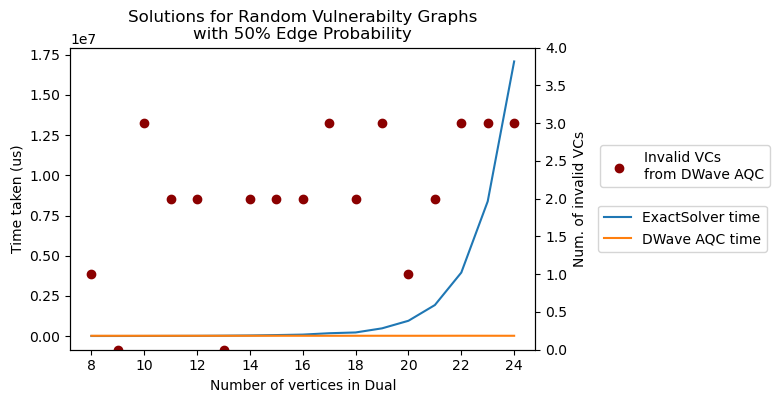

In [9]:
results1_average_times_c = []
for n in range(8,25):
    tmp = []
    for i in results1:
        if i['type'] == 'c' and i['num_nodes'] == n:
            tmp.append(i['time_us'].seconds * 1000000 + i['time_us'].microseconds)
    # we know that the number of runs was three
    results1_average_times_c.append(statistics.fmean(tmp))
    
results1_average_times_q = []    
for n in range(8,25):
    tmp = []
    for i in results1:
        if i['type'] == 'q' and i['num_nodes'] == n:
            tmp.append(i['time_us'])
    # we know that the number of runs was three
    results1_average_times_q.append(statistics.fmean(tmp))
    
results1_valid_q = []    
for n in range(8,25):
    tmp = 3
    for i in results1:
        if i['type'] == 'q' and i['num_nodes'] == n and i['valid'] == True:
            tmp -= 1
    # we know that the number of runs was three
    results1_valid_q.append(tmp)

print(results1_average_times_c)
print(results1_average_times_q)
print(results1_valid_q)
time_series = list(range(8,25))

fig,ax = plt.subplots()
ax.set_title("Solutions for Random Vulnerabilty Graphs\nwith 50% Edge Probability")
fig.set_dpi(100)
ax.plot(time_series, results1_average_times_c, label="ExactSolver time")
ax.plot(time_series, results1_average_times_q, label="DWave AQC time")
ax2 = ax.twinx()
ax2.scatter(time_series, results1_valid_q, label="Invalid VCs\nfrom DWave AQC", color='darkred')
ax2.set_ylabel("Num. of invalid VCs")
ax.set_xlabel("Number of vertices in Dual")
ax.set_ylabel("Time taken (us)")
ax2.set_ylim([0,4])
ax.legend(bbox_to_anchor =(1.12, 0.5))
ax2.legend(bbox_to_anchor =(1.52, 0.7))
plt.show()
fig.savefig("50pc-edge-probability.png")

[3677.3333333333335, 2485.3333333333335, 3812.3333333333335, 7738.0, 11649.0, 20335.666666666668, 33898.333333333336, 57864.0, 89678.33333333333, 137885.33333333334, 225831.0, 472617.6666666667, 945096.3333333334, 1912908.6666666667, 3950946.3333333335, 8257182.333333333, 18049568.0]
[16435.333333333332, 17851.666666666668, 17547.333333333332, 17464.0, 16582.553333333333, 16505.333333333332, 36734.0, 17940.0, 17403.666666666668, 17143.0, 16651.0, 17702.333333333332, 18166.333333333332, 17339.666666666668, 18667.333333333332, 16495.666666666668, 16306.0]
[0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]


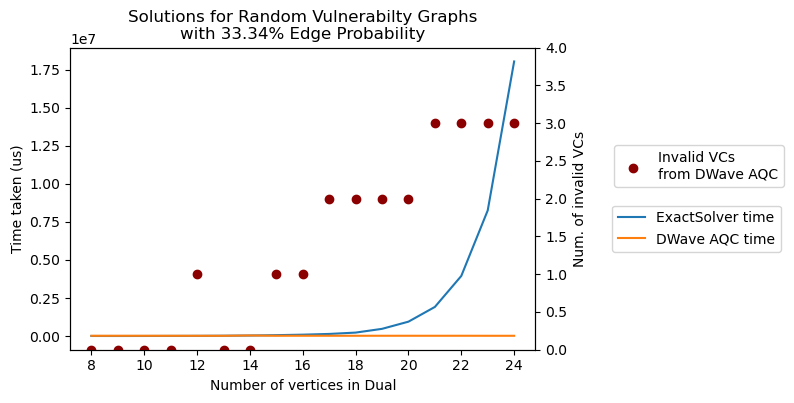

In [10]:
results2_average_times_c = []
for n in range(8,25):
    tmp = []
    for i in results2:
        if i['type'] == 'c' and i['num_nodes'] == n:
            tmp.append(i['time_us'].seconds * 1000000 + i['time_us'].microseconds)
    # we know that the number of runs was three
    results2_average_times_c.append(statistics.fmean(tmp))
    
results2_average_times_q = []    
for n in range(8,25):
    tmp = []
    for i in results2:
        if i['type'] == 'q' and i['num_nodes'] == n:
            tmp.append(i['time_us'])
    # we know that the number of runs was three
    results2_average_times_q.append(statistics.fmean(tmp))

results2_valid_q = []    
for n in range(8,25):
    tmp = 3
    for i in results2:
        if i['type'] == 'q' and i['num_nodes'] == n and i['valid'] == True:
            tmp -= 1
    # we know that the number of runs was three
    results2_valid_q.append(tmp)

print(results2_average_times_c)
print(results2_average_times_q)
print(results2_valid_q)
time_series = list(range(8,25))

fig,ax = plt.subplots()
ax.set_title("Solutions for Random Vulnerabilty Graphs\nwith 33.34% Edge Probability")
fig.set_dpi(100)
ax.plot(time_series, results2_average_times_c, label="ExactSolver time")
ax.plot(time_series, results2_average_times_q, label="DWave AQC time")
ax2 = ax.twinx()
ax2.scatter(time_series, results2_valid_q, label="Invalid VCs\nfrom DWave AQC", color='darkred')
ax2.set_ylabel("Num. of invalid VCs")
ax.set_xlabel("Number of vertices in Dual")
ax.set_ylabel("Time taken (us)")
ax2.set_ylim([0,4])
ax.legend(bbox_to_anchor =(1.15, 0.5))
ax2.legend(bbox_to_anchor =(1.55, 0.7))
plt.show()
fig.savefig("33pc-edge-probability.png")

[1911.6666666666667, 2734.3333333333335, 3385.0, 8022.666666666667, 11038.333333333334, 18499.333333333332, 29909.333333333332, 57489.0, 85638.33333333333, 128818.66666666667, 208862.33333333334, 388965.6666666667, 802647.0, 1590244.0, 3219998.3333333335, 6928612.0, 14240710.333333334]
[16982.0, 17395.666666666668, 16150.266666666668, 15646.0, 16214.0, 16114.0, 16129.333333333334, 16195.666666666666, 16473.666666666668, 16615.333333333332, 16617.666666666668, 16940.333333333332, 16615.0, 16001.0, 16636.0, 16599.333333333332, 17202.333333333332]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2]


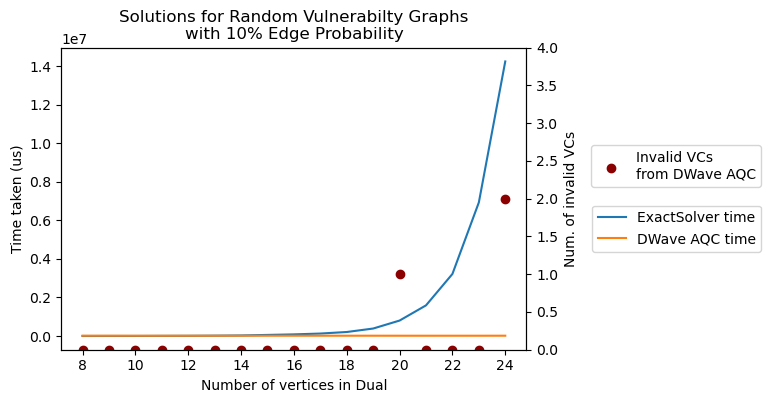

In [11]:
results3_average_times_c = []
for n in range(8,25):
    tmp = []
    for i in results3:
        if i['type'] == 'c' and i['num_nodes'] == n:
            tmp.append(i['time_us'].seconds * 1000000 + i['time_us'].microseconds)
    # we know that the number of runs was three
    results3_average_times_c.append(statistics.fmean(tmp))
    
results3_average_times_q = []    
for n in range(8,25):
    tmp = []
    for i in results3:
        if i['type'] == 'q' and i['num_nodes'] == n:
            tmp.append(i['time_us'])
    # we know that the number of runs was three
    results3_average_times_q.append(statistics.fmean(tmp))

results3_valid_q = []    
for n in range(8,25):
    tmp = 3
    for i in results3:
        if i['type'] == 'q' and i['num_nodes'] == n and i['valid'] == True:
            tmp -= 1
    # we know that the number of runs was three
    results3_valid_q.append(tmp)

print(results3_average_times_c)
print(results3_average_times_q)
print(results3_valid_q)
time_series = list(range(8,25))

fig,ax = plt.subplots()
ax.set_title("Solutions for Random Vulnerabilty Graphs\nwith 10% Edge Probability")
fig.set_dpi(100)
ax.plot(time_series, results3_average_times_c, label="ExactSolver time")
ax.plot(time_series, results3_average_times_q, label="DWave AQC time")
ax2 = ax.twinx()
ax2.scatter(time_series, results3_valid_q, label="Invalid VCs\nfrom DWave AQC", color='darkred')
ax2.set_ylabel("Num. of invalid VCs")
ax.set_xlabel("Number of vertices in Dual")
ax.set_ylabel("Time taken (us)")
ax2.set_ylim([0,4])
ax.legend(bbox_to_anchor =(1.52, 0.5))
ax2.legend(bbox_to_anchor =(1.52, 0.7))
plt.show()
fig.savefig("10pc-edge-probability.png")

[-0.3333333333333333, 0.3333333333333333, -0.6666666666666666, -0.6666666666666666, 0.3333333333333333, 0.6666666666666666, 0.0, -0.3333333333333333, -0.6666666666666666, -0.6666666666666666, -0.3333333333333333, -1.0, 0.0, -0.6666666666666666, -0.6666666666666666, -1.6666666666666667, -1.0]
[0.0, 0.0, 0.6666666666666666, 0.0, -0.3333333333333333, 1.0, 0.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.0, -0.3333333333333333, 0.0, 0.6666666666666666, -0.3333333333333333]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 1.0, 0.0, 0.6666666666666666, -0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666, -0.3333333333333333]


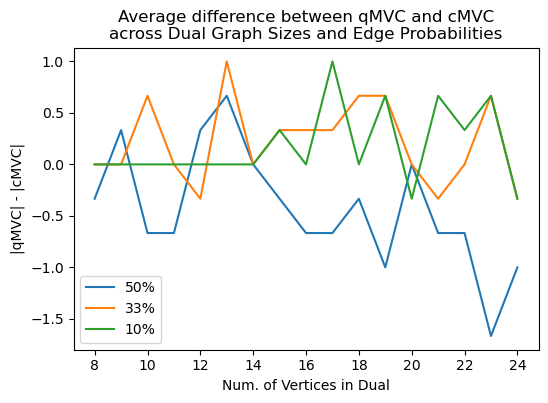

In [34]:
res1_mvc_delta = []
res2_mvc_delta = []
res3_mvc_delta = []

for i in range(0,len(results1),6):
    delta1 = results1[i+1]['vc_len'] - results1[i]['vc_len']
    delta2 = results1[i+3]['vc_len'] - results1[i+2]['vc_len']
    delta3 = results1[i+5]['vc_len'] - results1[i+4]['vc_len']
    res1_mvc_delta.append((delta1+delta2+delta3)/3)

for i in range(0,len(results2),6):
    delta1 = results2[i+1]['vc_len'] - results2[i]['vc_len']
    delta2 = results2[i+3]['vc_len'] - results2[i+2]['vc_len']
    delta3 = results2[i+5]['vc_len'] - results2[i+4]['vc_len']
    res2_mvc_delta.append((delta1+delta2+delta3)/3)
    
for i in range(0,len(results3),6):
    delta1 = results3[i+1]['vc_len'] - results3[i]['vc_len']
    delta2 = results3[i+3]['vc_len'] - results3[i+2]['vc_len']
    delta3 = results3[i+5]['vc_len'] - results3[i+4]['vc_len']
    res3_mvc_delta.append((delta1+delta2+delta3)/3)
    
print(res1_mvc_delta)
print(res2_mvc_delta)
print(res3_mvc_delta)
time_series = list(range(8,25))

mpl.rcParams['figure.dpi'] = 100
plt.plot(time_series, res1_mvc_delta, label='50%')
plt.plot(time_series, res2_mvc_delta, label='33%')
plt.plot(time_series, res3_mvc_delta, label='10%')
plt.legend()
plt.xlabel("Num. of Vertices in Dual")
plt.ylabel("|qMVC| - |cMVC|")
plt.title("Average difference between qMVC and cMVC\nacross Dual Graph Sizes and Edge Probabilities")
plt.show
plt.savefig("mvc-size-delta.png")

In [32]:
for i in results3_average_times_c:
    print(int(i))
    

1911
2734
3385
8022
11038
18499
29909
57489
85638
128818
208862
388965
802647
1590244
3219998
6928612
14240710


In [30]:

for i in res3_mvc_delta:
    print('{0:.3f}'.format(i))

0.000
0.000
0.000
0.000
0.000
0.000
0.000
0.333
0.000
1.000
0.000
0.667
-0.333
0.667
0.333
0.667
-0.333
